# **Tech Challenge 2**
## **Aluno:** Danilo Henrique Achcar RM 351516
## **Turma:** 2DTAT

# Introdução
Este notebook está dividido em 6 partes principais + 1 aplicação Streamlit externa:
1.   Análise exploratória dos dados a respeito dos fechamentos da Bovespa nos últimos 10 anos.
2.   Aplicação de ARIMA (statsmodels) e análise dos resultados
3.   Aplicação de modelos variados (StatsForecast) e análise dos resultados
4.   Aplicação do Prophet e análise de resultados
5.   Aplicação de Rede LSTM e análise de resultados
6.   Armazenamento do modelo LSTM e reteste
7.   Dashboard interativo via Streamlit



# Sobre a base de dados
Os dados foram coletados utilizando a biblioteca do Yahoo Finance e a distribuição é composta basicamente por 6 colunas:
* Open = preço de abertura do dia do ativo.
* High = maior preço alcançado no dia pelo ativo.
* Low = menor preço alcançado no dia pelo ativo.
* Close = preço de fechamento do dia do ativo (sem ajuste).
* Adj Close = preço de fechamento do dia do ativo (ajustado).
* Volume = volume de negócios que teve no dia para o ativo.

Para este estudo, analisaremos exclusivamente a variável **Close**.

# 1) Análise exploratória dos dados

## Obtendo os dados de fechamento da IBOVESPA

In [407]:
import yfinance as yf
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

In [408]:
# função para obter os dados de algum ativo (ticker)
def obter_dados_ticker(ticker: str, inicio: str = '2020-01-01', fim: str = '2023-12-24', save_output: bool = False) -> pd.DataFrame:
  ibovespa = yf.download(ticker, start=inicio, end=fim)

  print('Dados originais')
  ibovespa.info()

  df = pd.DataFrame(ibovespa, columns=['Close'])

  print('Dados tratados')
  ibovespa.info()

  if (save_output):
    ini_str = inicio.replace('-', '')
    fim_str = fim.replace('-', '')
    df.to_csv(f'bvsp-{ini_str}-{fim_str}.csv', sep=',')

  return df

In [409]:
# obtendo os dados do IBOVESPA via biblioteca do Yahoo Finance
df = obter_dados_ticker(ticker='^BVSP', save_output=True)
df.head()

[*********************100%%**********************]  1 of 1 completed
Dados originais
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 990 entries, 2020-01-02 to 2023-12-22
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       990 non-null    float64
 1   High       990 non-null    float64
 2   Low        990 non-null    float64
 3   Close      990 non-null    float64
 4   Adj Close  990 non-null    float64
 5   Volume     990 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 54.1 KB
Dados tratados
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 990 entries, 2020-01-02 to 2023-12-22
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       990 non-null    float64
 1   High       990 non-null    float64
 2   Low        990 non-null    float64
 3   Close      990 non-null    float64
 4   Adj Close  990 non-null    float64
 5 

,Close
Date,
2020-01-02,118573.0
2020-01-03,117707.0
2020-01-06,116878.0
2020-01-07,116662.0
2020-01-08,116247.0


In [410]:
df.shape

(990, 1)

In [411]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 990 entries, 2020-01-02 to 2023-12-22
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   990 non-null    float64
dtypes: float64(1)
memory usage: 15.5 KB


## Analisando a distribuição dos fechamentos do IBOVESPA ao longo dos anos<br/>(📅01/01/2020 ~ 📅24/12/2023)
Aqui podemos observar a natureza caótica do mercado de ações, analisando exclusivamente o índice da BOVESPA (IBOVESPA). Não há um padrão bem definido e num primeiro momento podemos observar que os dados possuem uma tendência de alta nos últimos meses. Por se tratar do mercado de ações, a melhor abordagem neste cenário seria com a utilização de TimeSeries ou até mesmo um modelo de rede neural para realizar previsões (como sugerido pela prof. Raquel).<br/><br/>
**Ainda assim, iremos comparar alguns outros métodos/modelos nas próximas seções e verificar os seus resultados.**

In [412]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

sns.set_style('whitegrid')

In [413]:
# função responsável por plotar o valor observado, a média móvel e o desvio padrão de uma distribuição de dados
def plot_timeseries(df: pd.DataFrame, x, y, legenda: str, ylabel: str, xlabel: str):
  plt.figure(figsize = (10, 8))

  ax = sns.lineplot(data=df, x=x, y=y, label=legenda)
  ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.2f}'))
  ax.set_xlabel(xlabel)
  ax.set_ylabel(ylabel)

  media = df.rolling(7).mean()
  sns.lineplot(data=media, x=media.index, y=y, color='r', label='Média')

  std = df.rolling(7).std()
  sns.lineplot(data=std, x=media.index, y=y, color='black', label='Desvio padrão')

  plt.grid(color='#ccc', linestyle='dashed', linewidth=1)
  plt.legend(loc='best')
  sns.despine()

  plt.show()

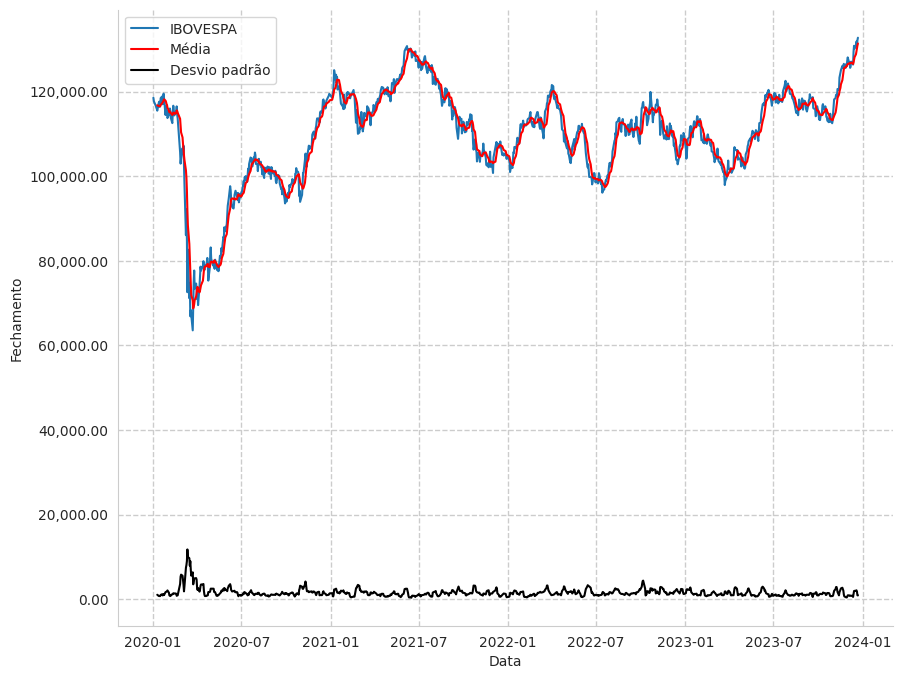

In [414]:
plot_timeseries(df, legenda='IBOVESPA', x=df.index, y='Close', xlabel='Data', ylabel='Fechamento')

## Decompondo a distribuição

### Comentário
Antes de prosseguirmos para a aplicação e validação dos modelos, vamos decompor esta distribuição (considerando que ela é uma timeseries) para analisar características de tendência, sazonalidade e ruído.

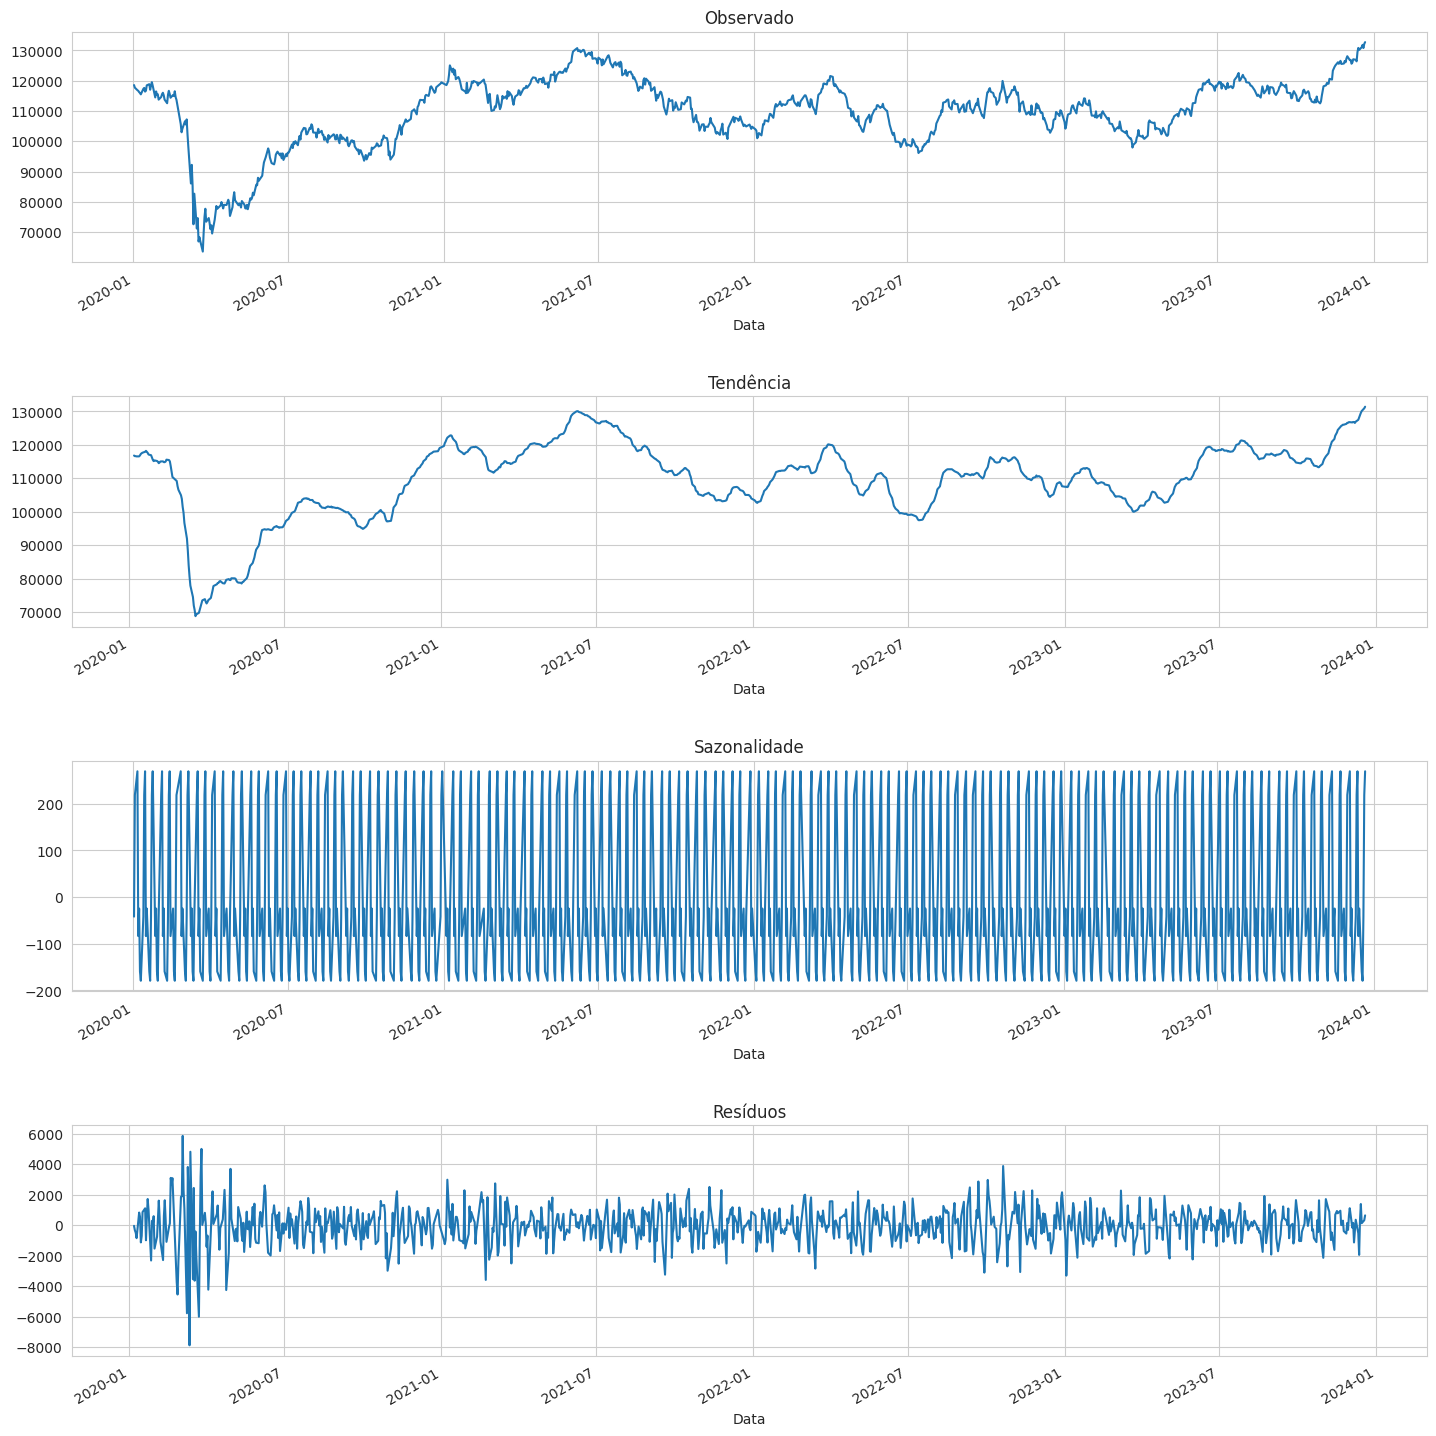

In [415]:
from statsmodels.tsa.seasonal import seasonal_decompose, STL

seasonplot = seasonal_decompose(df, period=7)
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15,15))
seasonplot.observed.plot(ax=ax1, title='Observado', xlabel='Data')
seasonplot.trend.plot(ax=ax2, title='Tendência', xlabel='Data')
seasonplot.seasonal.plot(ax=ax3, title='Sazonalidade', xlabel='Data')
seasonplot.resid.plot(ax=ax4, title='Resíduos', xlabel='Data')
plt.tight_layout(pad=3)

### Comentário
Para utilizarmos modelos de timeseries clássicos, é necessário que uma série seja estacionária. Para calcular a estacionariedade de uma série podemos utilizar o metodo ADF (Augmented Dickey-Fuller) para realizar um teste de hipótese, conforme a seguir:
- H0 (Hipótese Nula): A série temporal não é estacionária.
- H1 (Hipótese Alternativa): A série temporal é estacionária.

In [416]:
from statsmodels.tsa.stattools import adfuller

# função que verifica a estacionariedade de uma timeseries
def verifica_estacionariedade(series: pd.Series):
  result = adfuller(series)
  significancia = 0.05
  estacionario = result[1] <= 0.05

  print('Resultados ADF (Augmented Dickey-Fuller)')
  print(f'Teste estatístico: {result[0]}')
  print(f'P-Value: {result[1]}')
  print(f'Valores críticos:')

  for key, value in result[4].items():
    print(f'\t{key}: {value}')

  if estacionario:
    print('Rejeitamos a hipótese nula. A série apresenta evidências suficientes para ser classificada como ESTACIONÁRIA.')
  else:
    print('Não há evidências suficientes para rejeitarmos a hipótese nula. A série NÃO É ESTACIONÁRIA.')

# função que verifica a estacionariedade e plota a timeseries
def plot_estacionariedade(df: pd.DataFrame):
  verifica_estacionariedade(df.Close)
  plot_timeseries(df, legenda='IBOVESPA', x=df.index, y='Close', xlabel='Data', ylabel='Fechamento')

In [417]:
# verificando a estacionariedade da timeseries
verifica_estacionariedade(df.Close)

Resultados ADF (Augmented Dickey-Fuller)
Teste estatístico: -2.2315087188777514
P-Value: 0.19500896164453296
Valores críticos:
	1%: -3.4370266558635914
	5%: -2.864487711945291
	10%: -2.5683395116993872
Não há evidências suficientes para rejeitarmos a hipótese nula. A série NÃO É ESTACIONÁRIA.


# 2) Aplicação de ARIMA (statsmodels) e análise dos resultados
Conforme observado, nossa timeseries do fechamento do IBOVESPA não é estacionária. Para utilizarmos modelos clássicos, será necessário "estacionarmos" a distribuição através da remoção de sua sazonalidade e tendência, além de utilizarmos a diferenciação.

In [418]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

## 2.1) Obtendo o logaritmo da distribuição

Resultados ADF (Augmented Dickey-Fuller)
Teste estatístico: -2.58580980021923
P-Value: 0.09596570327399123
Valores críticos:
	1%: -3.4370334797663844
	5%: -2.8644907213150725
	10%: -2.568341114581742
Não há evidências suficientes para rejeitarmos a hipótese nula. A série NÃO É ESTACIONÁRIA.


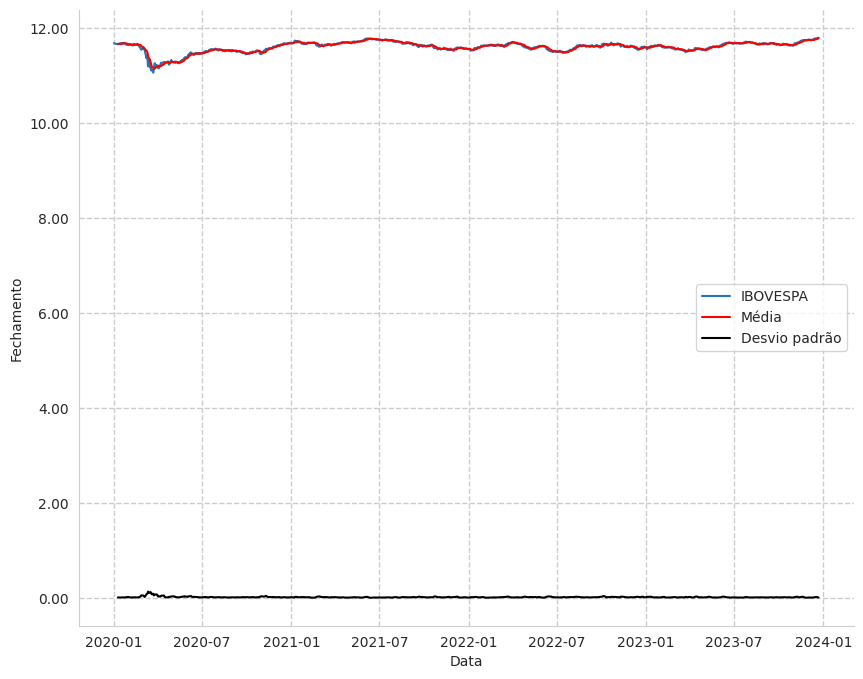

In [419]:
# vamos transformar os dados para a sua versão em logarítmo, de forma a torná-los mais "normais"
df_log = np.log(df)

plot_estacionariedade(df_log)

## 2.2) Removendo a média móvel da distribuição

Resultados ADF (Augmented Dickey-Fuller)
Teste estatístico: -7.821841168794052
P-Value: 6.638160031037919e-12
Valores críticos:
	1%: -3.437081640468809
	5%: -2.864511960193817
	10%: -2.568352427087857
Rejeitamos a hipótese nula. A série apresenta evidências suficientes para ser classificada como ESTACIONÁRIA.


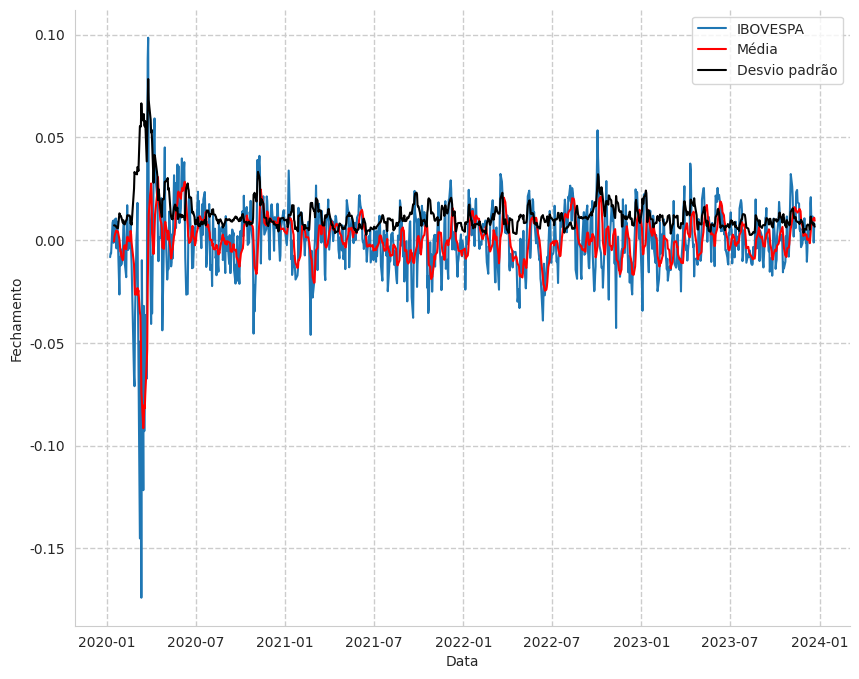

In [420]:
# vamos utilizar o valor 5 para a janela (considerando que os ativos são negociados entre segunda e sexta, a ideia seria a análise considerar esse 5 como 1 semana)
janela_movel = 5
df_mean = df_log.rolling(janela_movel).mean()
df_sem_media = (df_log - df_mean).dropna()

plot_estacionariedade(df_sem_media)

### Comentário
Podemos observar que ao remover a média móvel, a distribuição já se tornou estacionária! Mas ainda podemos executar outros passos para torná-la ainda mais estacionária.

## 2.3) Aplicando a diferenciação na distribuição

Resultados ADF (Augmented Dickey-Fuller)
Teste estatístico: -10.27662983444254
P-Value: 3.875392551604329e-18
Valores críticos:
	1%: -3.4371658366910216
	5%: -2.8645490899304784
	10%: -2.5683722036989813
Rejeitamos a hipótese nula. A série apresenta evidências suficientes para ser classificada como ESTACIONÁRIA.


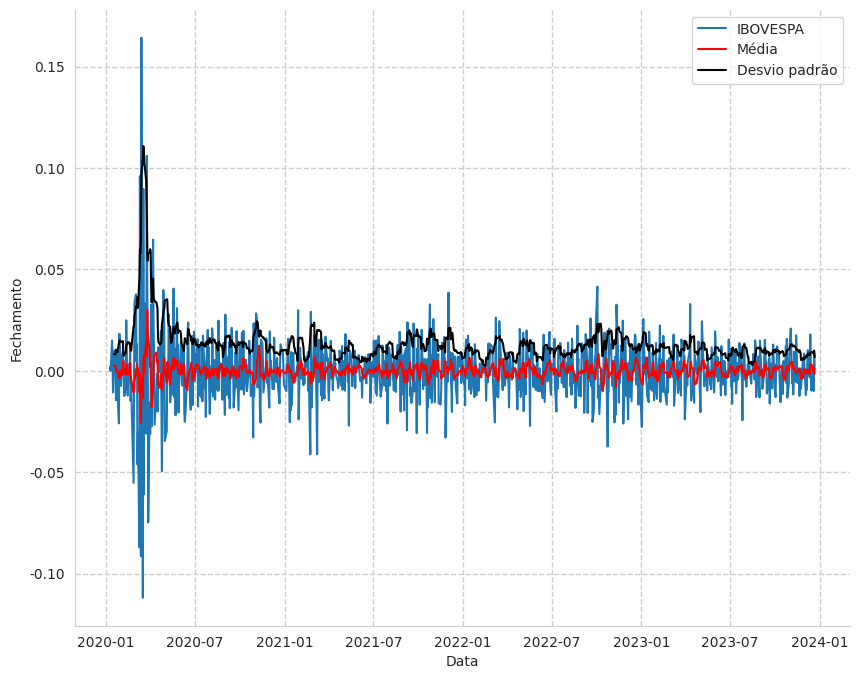

In [421]:
df_diff = df_sem_media.diff(1).dropna()

plot_estacionariedade(df_diff)

### Comentário
Agora que temos uma série bem estacionária, vamos utilizar o ACF (função de autocorrelação) e o PACF (função de autocorrelação parcial) para obter parâmetros importantes que serão utilizados junto do ARIMA.

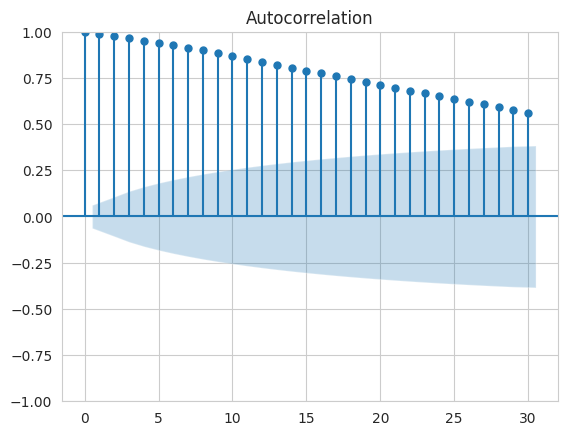

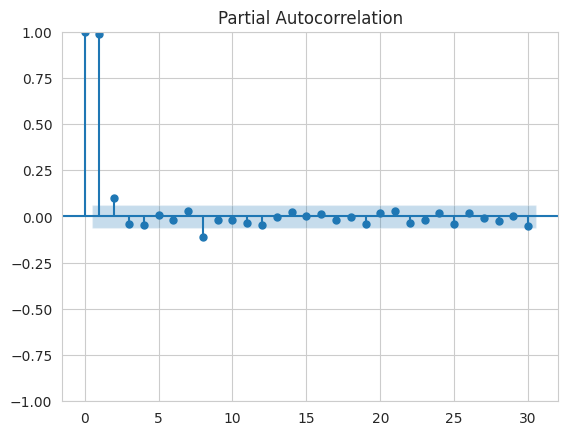

In [422]:
lag_acf = acf(df_diff, nlags=25)
lag_pacf = pacf(df_diff, nlags=25)

plot_acf(df.Close)
plot_pacf(df.Close)
plt.show()

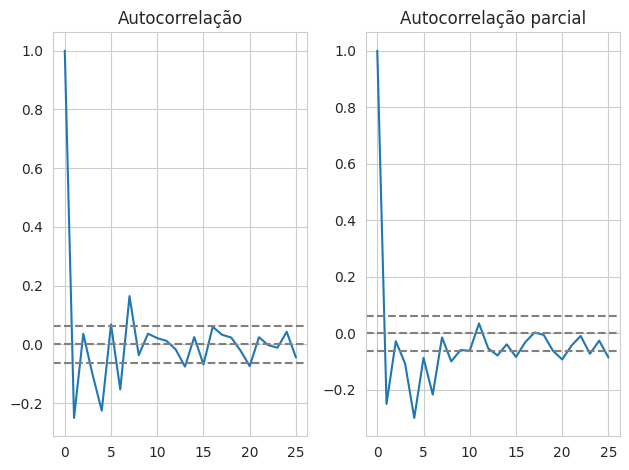

In [423]:
# ACF
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(df_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(df_diff)), linestyle='--', color='gray')
plt.title('Autocorrelação')

# PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(df_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(df_diff)), linestyle='--', color='gray')
plt.title('Autocorrelação parcial')

plt.tight_layout()

Resultado do modelo ARIMA


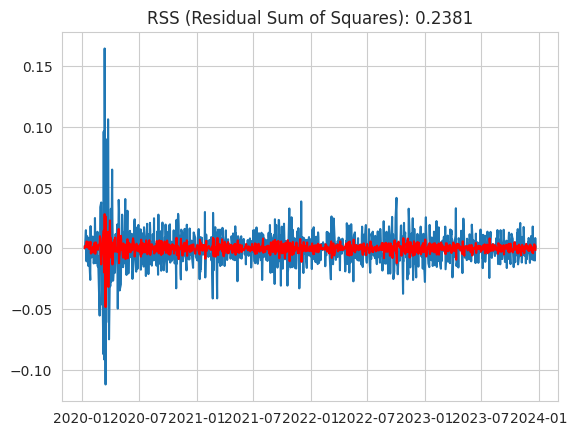

Outros indicadores:
AIC (Akaike Information Criterion): -5395.816470683911
BIC (Bayesian Information Criterion): -5371.358341198649
HQIC (Hannan-Quinn Information Criterion): -5386.5134003195135


In [424]:
arima_model = ARIMA(df_diff, order=(2,1,2))
arima_results = arima_model.fit()
arima_rss = sum((arima_results.fittedvalues - df_diff['Close']) ** 2)

print('Resultado do modelo ARIMA')
plt.plot(df_diff)
plt.plot(arima_results.fittedvalues, color='red')
plt.title(f'RSS (Residual Sum of Squares): {arima_rss:.4f}')
plt.show()

print('Outros indicadores:')
print(f'AIC (Akaike Information Criterion): {arima_results.aic}')
print(f'BIC (Bayesian Information Criterion): {arima_results.bic}')
print(f'HQIC (Hannan-Quinn Information Criterion): {arima_results.hqic}')

In [425]:
from sklearn.metrics import mean_absolute_error

# função que calcula o MAPE (Mean Absolute Percentage Error)
def calcular_mape_arima(df, df_diff, resultados_modelo):
  predictions = resultados_modelo.fittedvalues
  predictions.index = df_diff.index
  predicted_values = df['Close'].iloc[0] + np.cumsum(predictions)

  df.plot()
  predicted_values.plot()
  plt.show()

  # valor do MAPE
  mape = mean_absolute_error(df_diff['Close'], predicted_values) * 100

  print(f"MAPE: {mape:.2f}%")

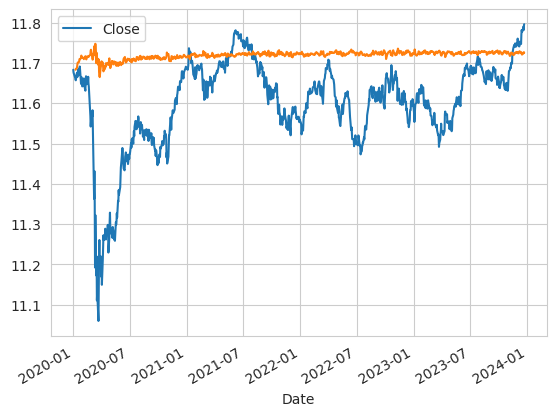

MAPE: 1171.96%


In [426]:
# calculando o MAPE do ARIMA
calcular_mape_arima(df_log, df_diff, arima_results)

### Comentário
O valor do MAPE (1171.96%) está muito alto! Também é possível observar que os valores preditos no gráfico estão bem longe da realidade. O modelo ARIMA não está performando bem. A seguir, aplicaremos outra abordagem.


# 3) Aplicação de modelos variados (StatsForecast) e análise dos resultados
Nesta seção, é aplicado os modelos baseline da biblioteca StatsForecast

In [427]:
!pip install statsforecast

In [428]:
# função para transformar o dataframe original num dataframe compatível com a biblioteca de StatsForecast
def transformar_df_para_forecasting(df: pd.DataFrame) -> pd.DataFrame:
  df_tratado = df.copy().reset_index()
  df_tratado.rename(columns={'Date':'ds', 'Close':'y'}, inplace=True)
  df_tratado['unique_id'] = df_tratado.index + 1

  return df_tratado

In [429]:
# transforma o dataframe original para um formato ao qual seja aceito no StatsForecast
df_tratado = transformar_df_para_forecasting(df)
df_tratado.head(10)

,ds,y,unique_id
0,2020-01-02,118573.0,1
1,2020-01-03,117707.0,2
2,2020-01-06,116878.0,3
3,2020-01-07,116662.0,4
4,2020-01-08,116247.0,5
5,2020-01-09,115947.0,6
6,2020-01-10,115503.0,7
7,2020-01-13,117325.0,8
8,2020-01-14,117632.0,9
9,2020-01-15,116414.0,10


In [430]:
df_tratado.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 990 entries, 0 to 989
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   ds         990 non-null    datetime64[ns]
 1   y          990 non-null    float64       
 2   unique_id  990 non-null    int64         
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 23.3 KB


In [431]:
# reordena e define o unique_id da distribuição
df_tratado = df_tratado[['unique_id', 'ds', 'y']]
df_tratado.unique_id = df_tratado.unique_id.astype(str)
df_tratado.unique_id = 'IBOVESPA'

In [432]:
df_tratado.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 990 entries, 0 to 989
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   unique_id  990 non-null    object        
 1   ds         990 non-null    datetime64[ns]
 2   y          990 non-null    float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 23.3+ KB


In [433]:
df_tratado.head()

,unique_id,ds,y
0,IBOVESPA,2020-01-02,118573.0
1,IBOVESPA,2020-01-03,117707.0
2,IBOVESPA,2020-01-06,116878.0
3,IBOVESPA,2020-01-07,116662.0
4,IBOVESPA,2020-01-08,116247.0


In [434]:
df_sf_treino = df_tratado.query('"2020-01-01" <= ds <= "2023-10-01"')
df_sf_validacao = df_tratado.query('"2023-10-02" <= ds <= "2023-12-15"')

In [435]:
df_sf_treino.head(10)

,unique_id,ds,y
0,IBOVESPA,2020-01-02,118573.0
1,IBOVESPA,2020-01-03,117707.0
2,IBOVESPA,2020-01-06,116878.0
3,IBOVESPA,2020-01-07,116662.0
4,IBOVESPA,2020-01-08,116247.0
5,IBOVESPA,2020-01-09,115947.0
6,IBOVESPA,2020-01-10,115503.0
7,IBOVESPA,2020-01-13,117325.0
8,IBOVESPA,2020-01-14,117632.0
9,IBOVESPA,2020-01-15,116414.0


In [436]:
df_sf_validacao.head(10)

,unique_id,ds,y
933,IBOVESPA,2023-10-02,115057.0
934,IBOVESPA,2023-10-03,113419.0
935,IBOVESPA,2023-10-04,113607.0
936,IBOVESPA,2023-10-05,113284.0
937,IBOVESPA,2023-10-06,114170.0
938,IBOVESPA,2023-10-09,115156.0
939,IBOVESPA,2023-10-10,116737.0
940,IBOVESPA,2023-10-11,117051.0
941,IBOVESPA,2023-10-13,115754.0
942,IBOVESPA,2023-10-16,116534.0


In [437]:
# função para preencher dias faltantes (finais de semana) com o preço de fechamento da sexta-feira
def preenche_dias_faltantes(df: pd.DataFrame) -> pd.DataFrame :
  clone = df.copy()
  clone['ds'] = pd.to_datetime(clone['ds'])
  clone = clone.set_index('ds')
  df_resampled = clone.resample('D').mean()
  df_resampled.reset_index(inplace=True)
  df_resampled.fillna(method='ffill', inplace=True)
  df_resampled['unique_id'] = 'IBOVESPA'

  return df_resampled

In [438]:
# adicionando dias faltantes (sábado e domingo) no dataframe (o valor utilizado é o mesmo da sexta-feira na semana em questão)
df_sf_treino = preenche_dias_faltantes(df_sf_treino)
df_sf_treino

,ds,y,unique_id
0,2020-01-02,118573.0,IBOVESPA
1,2020-01-03,117707.0,IBOVESPA
2,2020-01-04,117707.0,IBOVESPA
3,2020-01-05,117707.0,IBOVESPA
4,2020-01-06,116878.0,IBOVESPA
...,...,...,...
1362,2023-09-25,115925.0,IBOVESPA
1363,2023-09-26,114193.0,IBOVESPA
1364,2023-09-27,114327.0,IBOVESPA
1365,2023-09-28,115731.0,IBOVESPA


In [439]:
df_sf_validacao.head(10)

,unique_id,ds,y
933,IBOVESPA,2023-10-02,115057.0
934,IBOVESPA,2023-10-03,113419.0
935,IBOVESPA,2023-10-04,113607.0
936,IBOVESPA,2023-10-05,113284.0
937,IBOVESPA,2023-10-06,114170.0
938,IBOVESPA,2023-10-09,115156.0
939,IBOVESPA,2023-10-10,116737.0
940,IBOVESPA,2023-10-11,117051.0
941,IBOVESPA,2023-10-13,115754.0
942,IBOVESPA,2023-10-16,116534.0


In [440]:
df_sf_validacao = preenche_dias_faltantes(df_sf_validacao)
df_sf_validacao

,ds,y,unique_id
0,2023-10-02,115057.0,IBOVESPA
1,2023-10-03,113419.0,IBOVESPA
2,2023-10-04,113607.0,IBOVESPA
3,2023-10-05,113284.0,IBOVESPA
4,2023-10-06,114170.0,IBOVESPA
...,...,...,...
70,2023-12-11,126916.0,IBOVESPA
71,2023-12-12,126403.0,IBOVESPA
72,2023-12-13,129465.0,IBOVESPA
73,2023-12-14,130842.0,IBOVESPA


In [441]:
df_sf_validacao.head(10)

,ds,y,unique_id
0,2023-10-02,115057.0,IBOVESPA
1,2023-10-03,113419.0,IBOVESPA
2,2023-10-04,113607.0,IBOVESPA
3,2023-10-05,113284.0,IBOVESPA
4,2023-10-06,114170.0,IBOVESPA
5,2023-10-07,114170.0,IBOVESPA
6,2023-10-08,114170.0,IBOVESPA
7,2023-10-09,115156.0,IBOVESPA
8,2023-10-10,116737.0,IBOVESPA
9,2023-10-11,117051.0,IBOVESPA


In [442]:
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA, Naive, SeasonalNaive, WindowAverage, SeasonalWindowAverage
from statsforecast.utils import ConformalIntervals

intervals = ConformalIntervals(h=60, n_windows=4)

# aplica o StatsForecast com 5 modelos (alguns deles sendo de baseline para fins comparativos)
# dentre os modelos utilizados estão: Naive, SeasonalNaive, WindowAverage, SeasonalWindowAverage e AutoARIMA
# Um ponto interessante sobre o AutoARIMA é que ele escolhe os melhores hiperparâmetros automaticamente, por isso o "Auto" no nome!
sf = StatsForecast(
    models = [
      Naive(),
      SeasonalNaive(season_length=60),
      WindowAverage(window_size=60, prediction_intervals=intervals),
      SeasonalWindowAverage(window_size=7, season_length=60, prediction_intervals=intervals),
      AutoARIMA(season_length = 60)
    ],
    freq = 'D',
    n_jobs=-1
)

sf.fit(df_sf_treino)

StatsForecast(models=[Naive,SeasonalNaive,WindowAverage,SeasWA,AutoARIMA])

In [443]:
# nosso horizonte de previsão será de 60 dias e iremos executar os modelos para gerar predições com 3 níveis de confiança (70%, 80% e 90%)
df_forecast = sf.predict(h=60, level=[70, 80, 90])
df_forecast.reset_index(inplace=True)

In [444]:
df_forecast.head(10)

,unique_id,ds,Naive,Naive-lo-70,Naive-lo-80,Naive-lo-90,Naive-hi-70,Naive-hi-80,Naive-hi-90,SeasonalNaive,...,SeasWA-hi-70,SeasWA-hi-80,SeasWA-hi-90,AutoARIMA,AutoARIMA-lo-90,AutoARIMA-lo-80,AutoARIMA-lo-70,AutoARIMA-hi-70,AutoARIMA-hi-80,AutoARIMA-hi-90
0,IBOVESPA,2023-09-30,116565.0,115068.328125,114714.367188,114189.742188,118061.671875,118415.632812,118940.257812,121248.0,...,120843.718750,121351.023438,121471.226562,116473.0,114107.625000,114630.070312,114982.562500,117963.445312,118315.937500,118838.382812
1,IBOVESPA,2023-10-01,116565.0,114448.390625,113947.812500,113205.875000,118681.609375,119182.187500,119924.125000,120859.0,...,119859.937500,120391.390625,120625.195312,116473.0,113282.968750,113987.554688,114462.937500,118483.070312,118958.453125,119663.039062
2,IBOVESPA,2023-10-02,116565.0,113972.695312,113359.609375,112450.929688,119157.304688,119770.390625,120679.070312,120586.0,...,120231.085938,120710.109375,120854.906250,116473.0,112631.437500,113479.929688,114052.406250,118893.601562,119466.078125,120314.570312
3,IBOVESPA,2023-10-03,116565.0,113571.664062,112863.734375,111814.476562,119558.335938,120266.265625,121315.523438,119508.0,...,119192.429688,119914.968750,120389.765625,116473.0,112075.390625,113046.703125,113702.039062,119243.968750,119899.304688,120870.617188
4,IBOVESPA,2023-10-04,116565.0,113218.343750,112426.859375,111253.750000,119911.656250,120703.140625,121876.250000,119508.0,...,119263.101562,120030.601562,120640.296875,116473.0,111582.164062,112662.414062,113391.250000,119554.750000,120283.593750,121363.843750
5,IBOVESPA,2023-10-05,116565.0,112898.929688,112031.890625,110746.820312,120231.070312,121098.109375,122383.179688,119508.0,...,119307.000000,120016.375000,120609.476562,116473.0,111134.312500,112313.476562,113109.054688,119836.945312,120632.523438,121811.695312
6,IBOVESPA,2023-10-06,116565.0,112605.187500,111668.687500,110280.648438,120524.812500,121461.312500,122849.351562,119380.0,...,119185.398438,120249.578125,121264.085938,116473.0,110721.226562,111991.632812,112848.773438,120097.234375,120954.375000,122224.781250
7,IBOVESPA,2023-10-07,116565.0,112331.781250,111330.617188,109846.742188,120798.218750,121799.382812,123283.257812,119090.0,...,118986.453125,119753.390625,120527.343750,116473.0,110335.882812,111691.398438,112605.960938,120340.046875,121254.609375,122610.125000
8,IBOVESPA,2023-10-08,116565.0,112074.992188,111013.101562,109439.218750,121055.007812,122116.898438,123690.781250,118409.0,...,117237.367188,117596.898438,118002.953125,116473.0,109973.343750,111408.937500,112377.523438,120568.484375,121537.070312,122972.664062
9,IBOVESPA,2023-10-09,116565.0,111832.117188,110712.781250,109053.765625,121297.882812,122417.218750,124076.234375,118350.0,...,116957.906250,117418.296875,117884.148438,116473.0,109629.984375,111141.414062,112161.171875,120784.835938,121804.593750,123316.023438


In [445]:
# junta o dataframe original com o dataframe de forecast para comparação
df_forecast_merged = df_forecast.merge(df_sf_validacao, how='left', on=['unique_id', 'ds'])
df_forecast_merged.dropna(inplace=True)
df_forecast_merged.head(20)

,unique_id,ds,Naive,Naive-lo-70,Naive-lo-80,Naive-lo-90,Naive-hi-70,Naive-hi-80,Naive-hi-90,SeasonalNaive,...,SeasWA-hi-80,SeasWA-hi-90,AutoARIMA,AutoARIMA-lo-90,AutoARIMA-lo-80,AutoARIMA-lo-70,AutoARIMA-hi-70,AutoARIMA-hi-80,AutoARIMA-hi-90,y
2,IBOVESPA,2023-10-02,116565.0,113972.695312,113359.609375,112450.929688,119157.304688,119770.390625,120679.070312,120586.0,...,120710.109375,120854.906250,116473.0,112631.437500,113479.929688,114052.406250,118893.601562,119466.078125,120314.570312,115057.0
3,IBOVESPA,2023-10-03,116565.0,113571.664062,112863.734375,111814.476562,119558.335938,120266.265625,121315.523438,119508.0,...,119914.968750,120389.765625,116473.0,112075.390625,113046.703125,113702.039062,119243.968750,119899.304688,120870.617188,113419.0
4,IBOVESPA,2023-10-04,116565.0,113218.343750,112426.859375,111253.750000,119911.656250,120703.140625,121876.250000,119508.0,...,120030.601562,120640.296875,116473.0,111582.164062,112662.414062,113391.250000,119554.750000,120283.593750,121363.843750,113607.0
5,IBOVESPA,2023-10-05,116565.0,112898.929688,112031.890625,110746.820312,120231.070312,121098.109375,122383.179688,119508.0,...,120016.375000,120609.476562,116473.0,111134.312500,112313.476562,113109.054688,119836.945312,120632.523438,121811.695312,113284.0
6,IBOVESPA,2023-10-06,116565.0,112605.187500,111668.687500,110280.648438,120524.812500,121461.312500,122849.351562,119380.0,...,120249.578125,121264.085938,116473.0,110721.226562,111991.632812,112848.773438,120097.234375,120954.375000,122224.781250,114170.0
7,IBOVESPA,2023-10-07,116565.0,112331.781250,111330.617188,109846.742188,120798.218750,121799.382812,123283.257812,119090.0,...,119753.390625,120527.343750,116473.0,110335.882812,111691.398438,112605.960938,120340.046875,121254.609375,122610.125000,114170.0
8,IBOVESPA,2023-10-08,116565.0,112074.992188,111013.101562,109439.218750,121055.007812,122116.898438,123690.781250,118409.0,...,117596.898438,118002.953125,116473.0,109973.343750,111408.937500,112377.523438,120568.484375,121537.070312,122972.664062,114170.0
9,IBOVESPA,2023-10-09,116565.0,111832.117188,110712.781250,109053.765625,121297.882812,122417.218750,124076.234375,118350.0,...,117418.296875,117884.148438,116473.0,109629.984375,111141.414062,112161.171875,120784.835938,121804.593750,123316.023438,115156.0
10,IBOVESPA,2023-10-10,116565.0,111601.109375,110427.148438,108687.148438,121528.890625,122702.851562,124442.851562,118065.0,...,117554.703125,117809.851562,116473.0,109303.046875,110886.695312,111955.164062,120990.835938,122059.312500,123642.960938,116737.0
11,IBOVESPA,2023-10-11,116565.0,111380.390625,110154.218750,108336.851562,121749.609375,122975.781250,124793.148438,118065.0,...,117139.601562,117602.296875,116473.0,108990.382812,110643.085938,111758.156250,121187.851562,122302.921875,123955.617188,117051.0


In [446]:
df_forecast_merged[df_forecast_merged.isnull().any(axis=1)]

,unique_id,ds,Naive,Naive-lo-70,Naive-lo-80,Naive-lo-90,Naive-hi-70,Naive-hi-80,Naive-hi-90,SeasonalNaive,...,SeasWA-hi-80,SeasWA-hi-90,AutoARIMA,AutoARIMA-lo-90,AutoARIMA-lo-80,AutoARIMA-lo-70,AutoARIMA-hi-70,AutoARIMA-hi-80,AutoARIMA-hi-90,y


In [447]:
plot_last_days = 180
niveis_de_confiaca = [70, 80, 90]

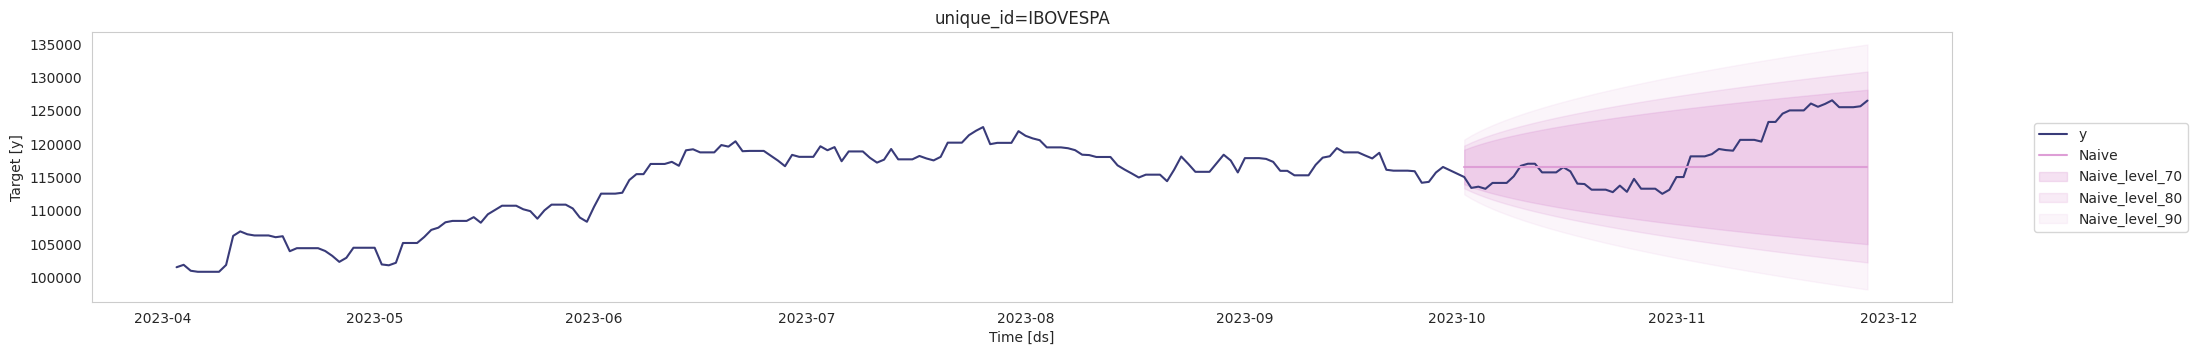

In [448]:
sf.plot(df_sf_treino.tail(plot_last_days), df_forecast_merged, models=['Naive'], level=niveis_de_confiaca)

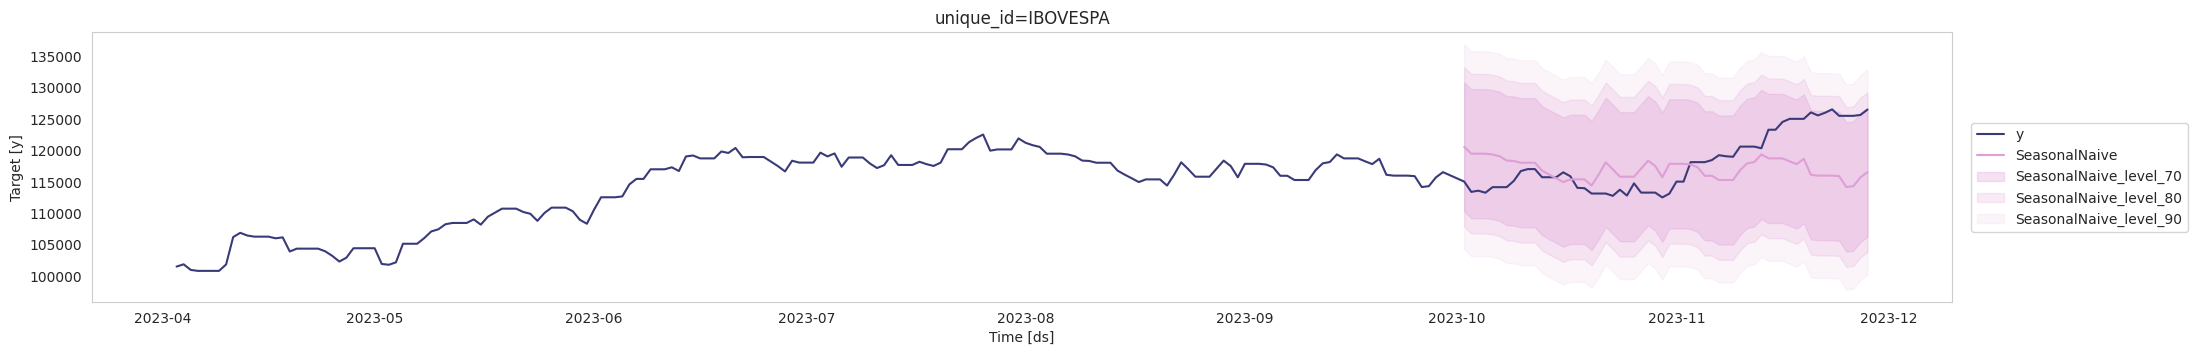

In [449]:
sf.plot(df_sf_treino.tail(plot_last_days), df_forecast_merged, models=['SeasonalNaive'], level=niveis_de_confiaca)

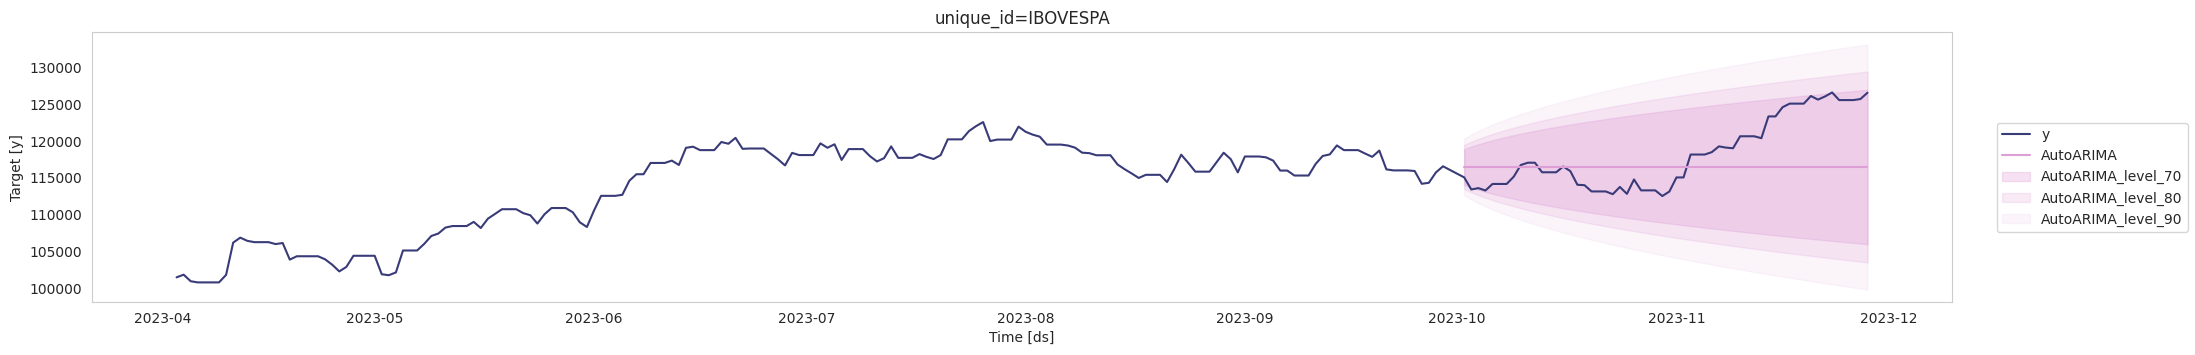

In [450]:
sf.plot(df_sf_treino.tail(plot_last_days), df_forecast_merged, models=['AutoARIMA'], level=niveis_de_confiaca)

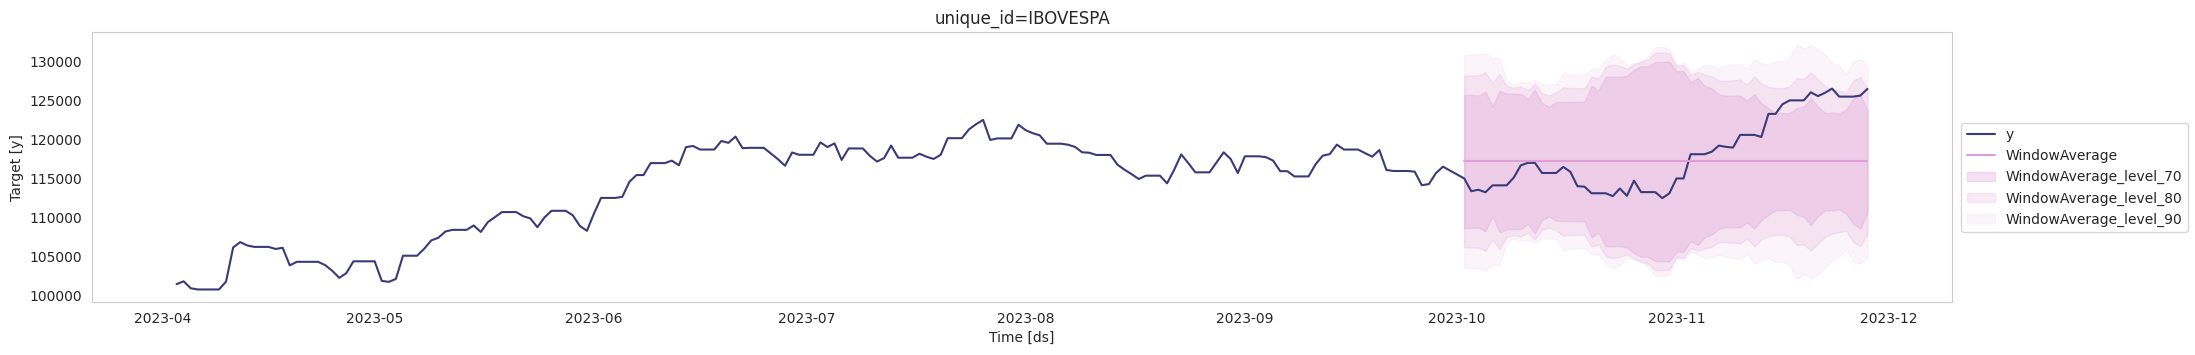

In [451]:
sf.plot(df_sf_treino.tail(plot_last_days), df_forecast_merged, models=['WindowAverage'], level=niveis_de_confiaca)

In [452]:
sf.plot(df_sf_treino.tail(plot_last_days), df_forecast_merged, models=['SeasWA'], level=niveis_de_confiaca, engine='plotly')

### Comentário
As predições de todos os 5 modelos não se saíram muito bem, analisando apenas o gráfico. A seguir, iremos verificar o WMAPE para cada um e plotar exclusivamente o trecho predito VS a realidade.

In [453]:
# função para cálculo do WMAPE
def wmape(y_true, y_pred):
  return np.abs(y_true - y_pred).sum() / np.abs(y_true).sum()

# função para plot e execução do WMAPE, por modelo
def plot_statsforecast_prediction(df_forecasted: pd.DataFrame):
  df = df_forecasted.copy()

  for model_ in ['Naive', 'SeasonalNaive', 'WindowAverage', 'SeasWA', 'AutoARIMA']:
    fig, ax = plt.subplots(1, 1, figsize=(1280/96, 720/96))

    for ax_, agrupamento in enumerate(['IBOVESPA']):
      df.loc[df['unique_id'] == agrupamento].plot(x='ds', y='y', ax=ax, label='y', title=agrupamento, linewidth=2)
      df.loc[df['unique_id'] == agrupamento].plot(x='ds', y=model_, ax=ax, label=model_)
      ax.set_xlabel('Data')
      ax.set_ylabel('Pontos')

      # 90% confiança
      ax.fill_between(
        df.loc[df['unique_id'] == agrupamento, 'ds'].values,
        df.loc[df['unique_id'] == agrupamento, f'{model_}-lo-90'],
        df.loc[df['unique_id'] == agrupamento, f'{model_}-hi-90'],
        alpha=0.1,
        color='orange'
      )

      # 80% confiança
      ax.fill_between(
        df.loc[df['unique_id'] == agrupamento, 'ds'].values,
        df.loc[df['unique_id'] == agrupamento, f'{model_}-lo-80'],
        df.loc[df['unique_id'] == agrupamento, f'{model_}-hi-80'],
        alpha=0.1,
        color='red'
      )

      ax.set_title(f'{agrupamento} - Rasura em amarelo = 90% de confiança / Rasura em vermelho = 80% de confiança')
      ax.legend()

    fig.tight_layout()

    wmape_ = wmape(df['y'].values, df[model_].values)
    print(f'{model_} - WMAPE: {wmape_:.2%}')

Naive - WMAPE: 3.40%
SeasonalNaive - WMAPE: 3.68%
WindowAverage - WMAPE: 3.42%
SeasWA - WMAPE: 5.60%
AutoARIMA - WMAPE: 3.40%


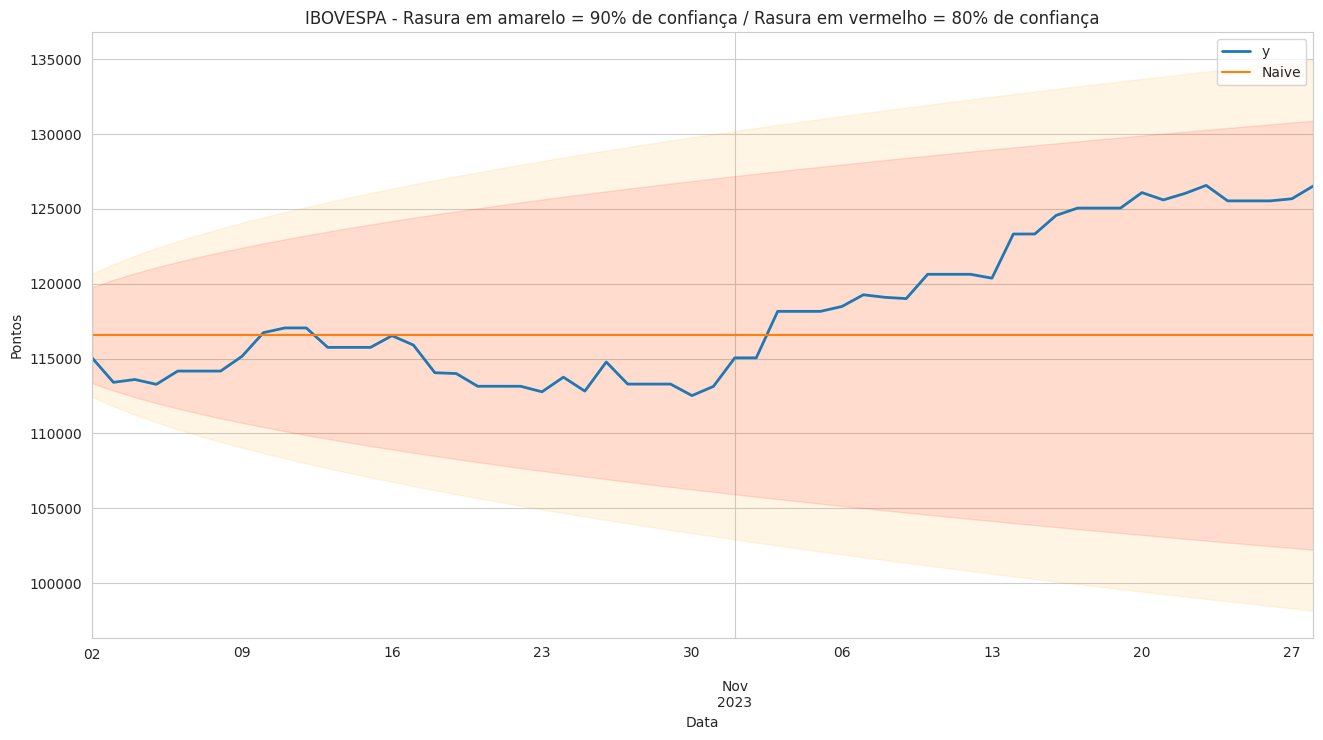

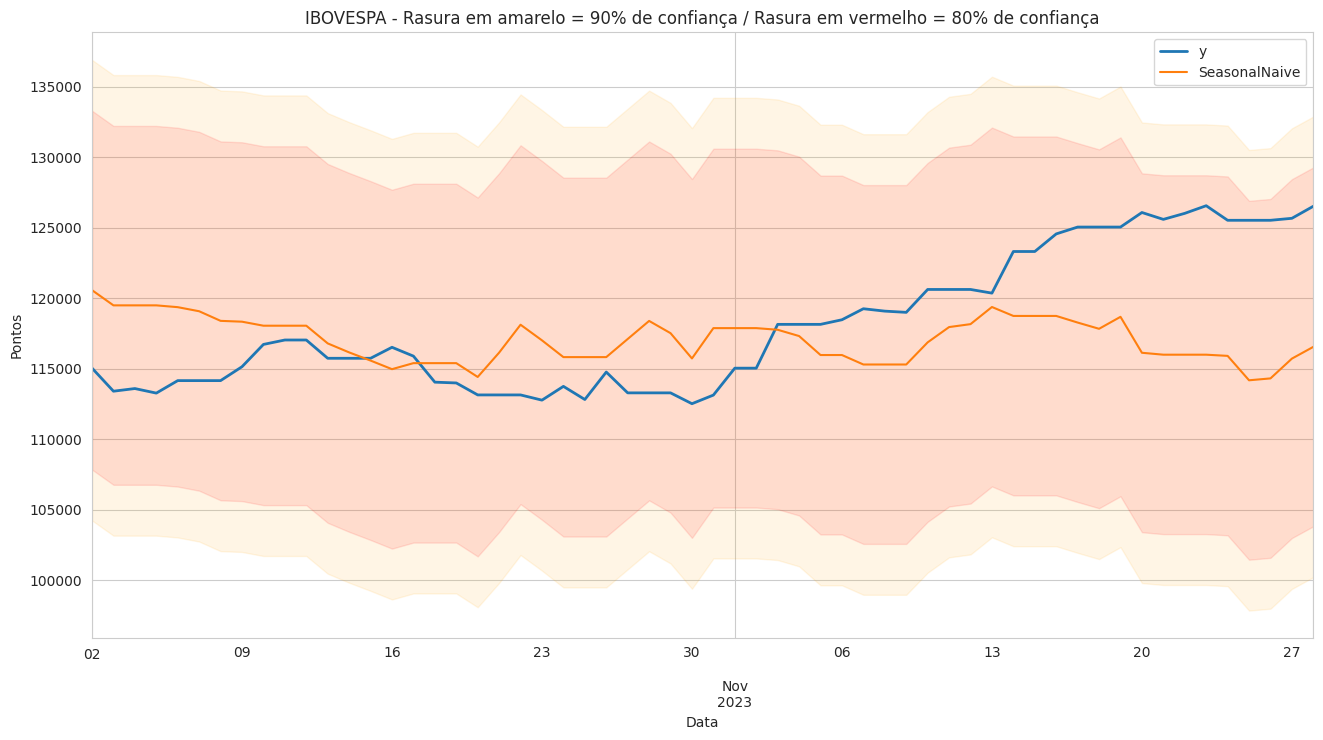

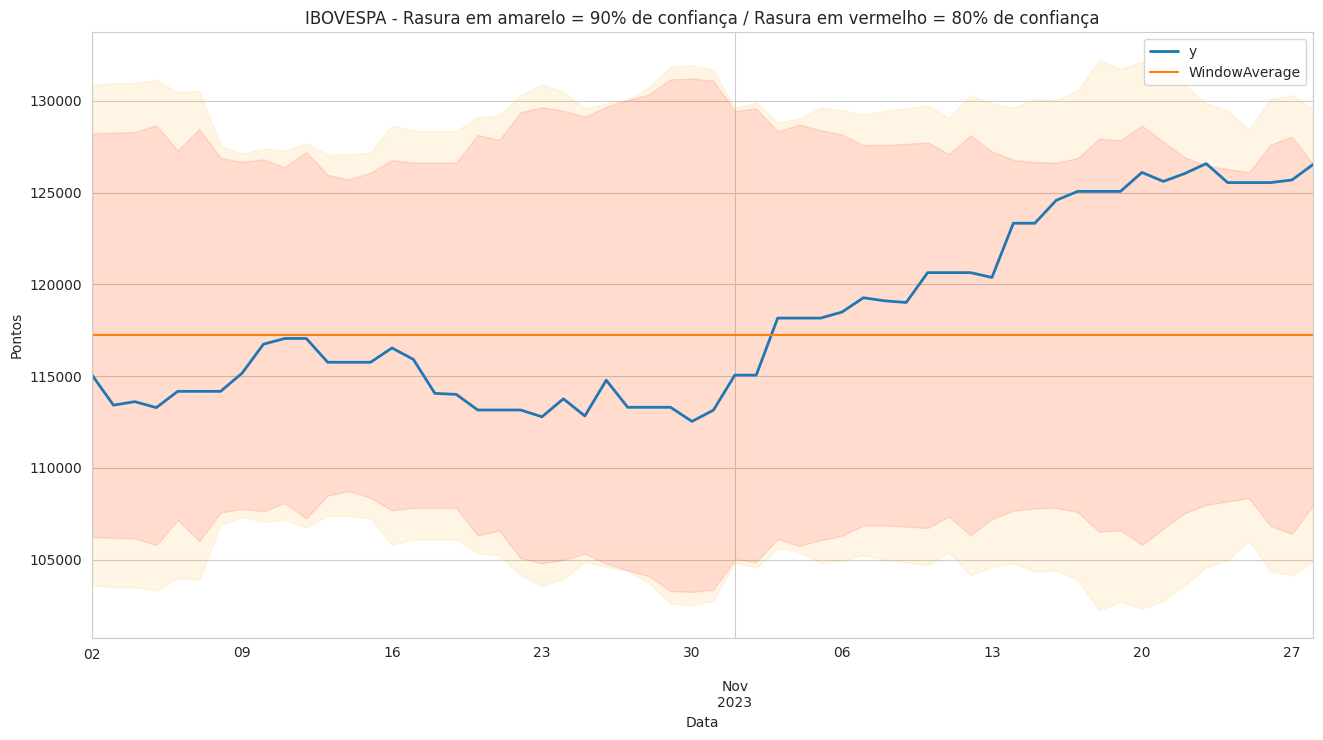

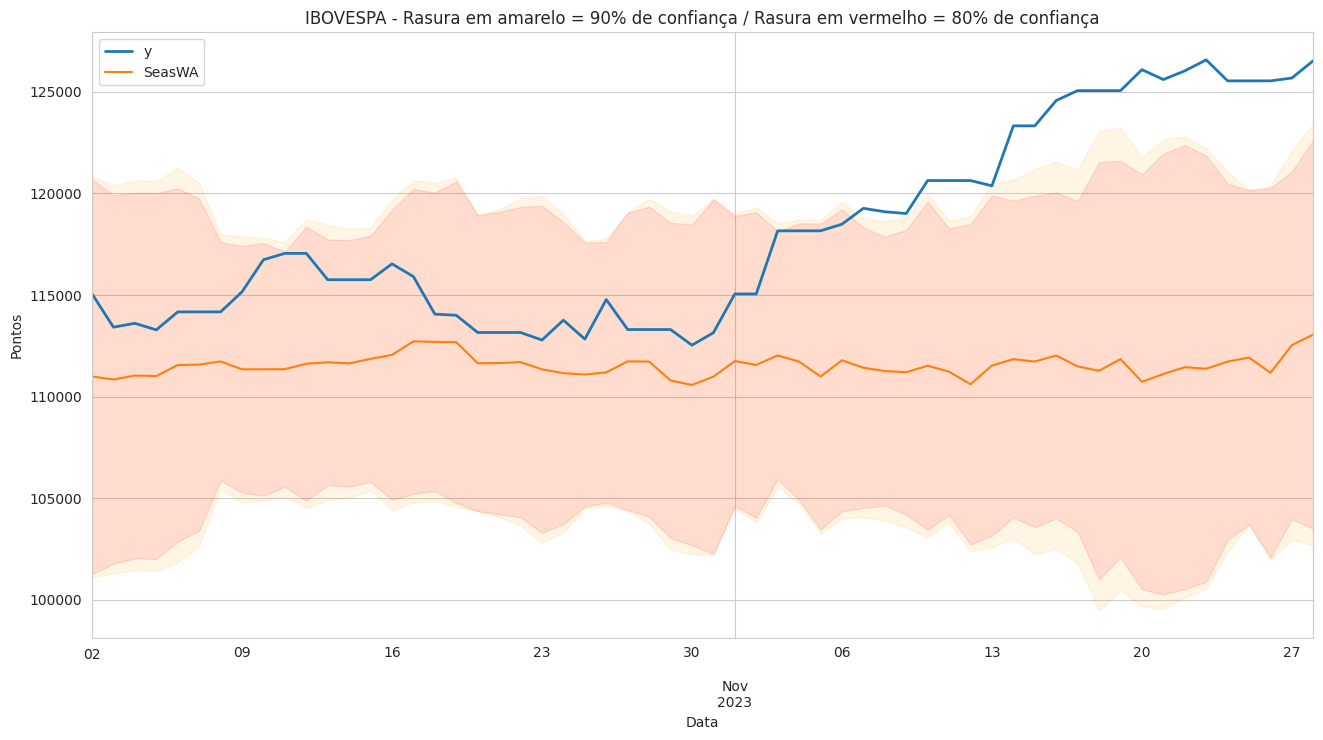

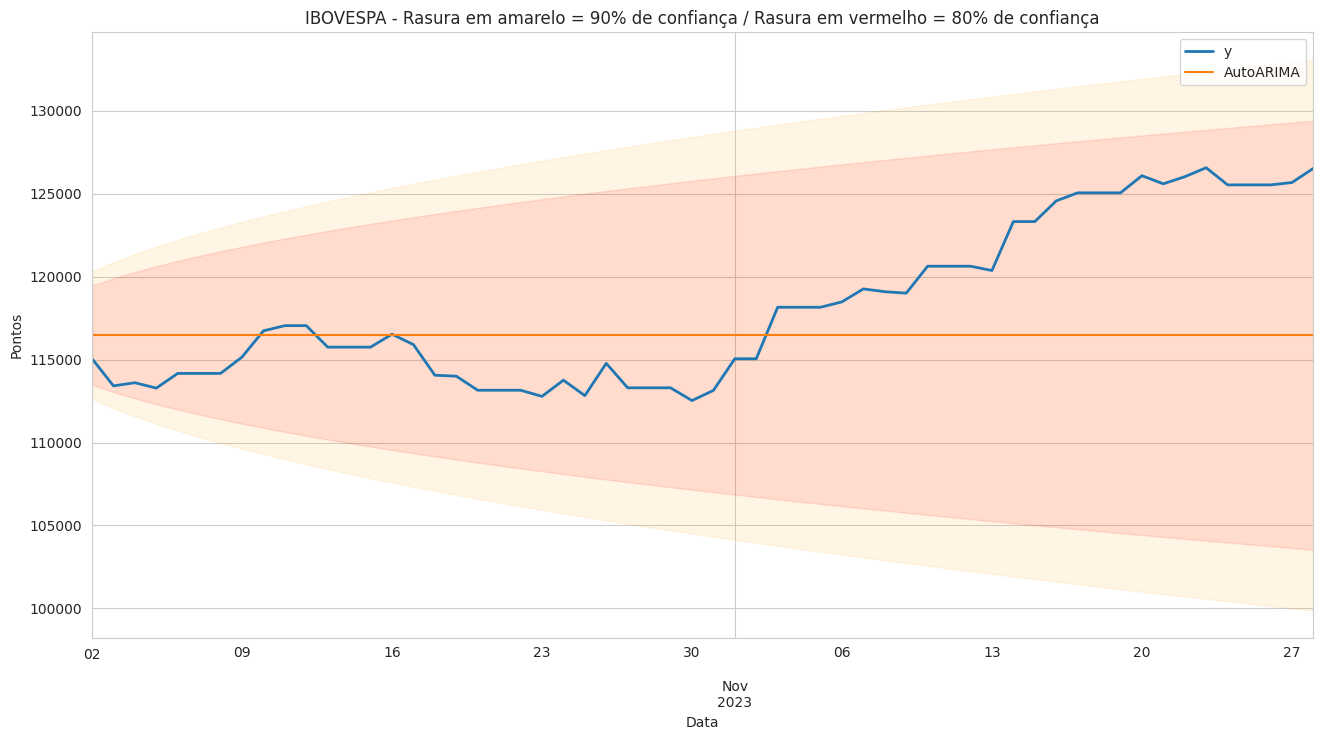

In [454]:
plot_statsforecast_prediction(df_forecast_merged)

### Comentário
Conforme visto, as predições por modelo e considerando os níveis de confiança de 80% e 90%, nenhum modelo foi satisfatória em suas prediçoes, apesar de todos terem apresentado um baixo WMAPE. Entretanto, o propósito aqui era mais voltado a executar modelos baseline para compararmos com outras abordagens.

# 4) Aplicação do Prophet e análise de resultados
Nesta seção, é aplicado o Prophet da Meta na timeseries do IBOVESPA

In [455]:
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly

In [456]:
df_tratado = transformar_df_para_forecasting(df)
train_data = df_tratado.sample(frac=0.8, random_state=0)
test_data = df_tratado.drop(train_data.index)

In [457]:
# instancia o Prophet e prevê os próximos 90 dias
modelo = Prophet(daily_seasonality=True)
modelo.fit(train_data)
df_futuro = modelo.make_future_dataframe(periods=90, freq='D')
previsao = modelo.predict(df_futuro)
previsao.head()

DEBUG:cmdstanpy:input tempfile: /tmp/tmpv5n8rnw4/jjdsvvpj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv5n8rnw4/myn275zw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5448', 'data', 'file=/tmp/tmpv5n8rnw4/jjdsvvpj.json', 'init=/tmp/tmpv5n8rnw4/myn275zw.json', 'output', 'file=/tmp/tmpv5n8rnw4/prophet_model0do00q6o/prophet_model-20240102005644.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:56:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:56:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-01-02,116521.423443,111363.675544,124082.259726,116521.423443,116521.423443,1117.862733,1117.862733,1117.862733,-288.884865,...,53.381442,53.381442,53.381442,1353.366157,1353.366157,1353.366157,0.0,0.0,0.0,117639.286176
1,2020-01-03,116183.209998,111198.647671,123257.356342,116183.209998,116183.209998,1125.429514,1125.429514,1125.429514,-288.884865,...,56.137866,56.137866,56.137866,1358.176513,1358.176513,1358.176513,0.0,0.0,0.0,117308.639513
2,2020-01-06,115168.569664,110588.787815,122542.066551,115168.569664,115168.569664,1308.475207,1308.475207,1308.475207,-288.884865,...,101.929994,101.929994,101.929994,1495.430079,1495.430079,1495.430079,0.0,0.0,0.0,116477.044871
3,2020-01-07,114830.356219,110495.843819,122234.300384,114830.356219,114830.356219,1204.653730,1204.653730,1204.653730,-288.884865,...,-89.648982,-89.648982,-89.648982,1583.187578,1583.187578,1583.187578,0.0,0.0,0.0,116035.009949
4,2020-01-08,114492.142774,109714.967230,121479.582853,114492.142774,114492.142774,1208.556028,1208.556028,1208.556028,-288.884865,...,-194.021456,-194.021456,-194.021456,1691.462349,1691.462349,1691.462349,0.0,0.0,0.0,115700.698803


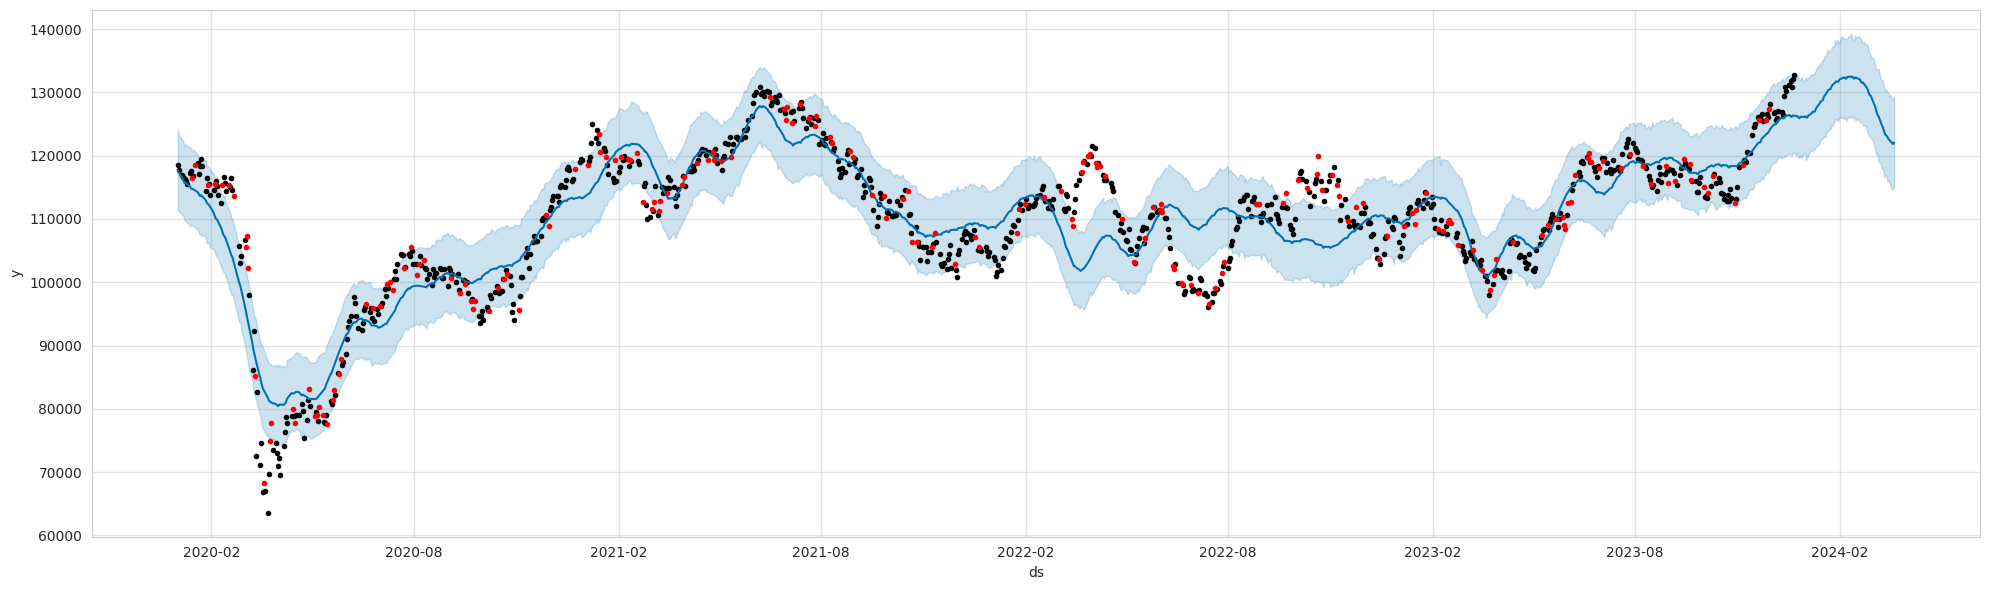

In [458]:
modelo.plot(previsao, figsize=(20,6));
plt.plot(test_data['ds'], test_data['y'], '.r')

In [459]:
plot_plotly(modelo, previsao, trend=True)

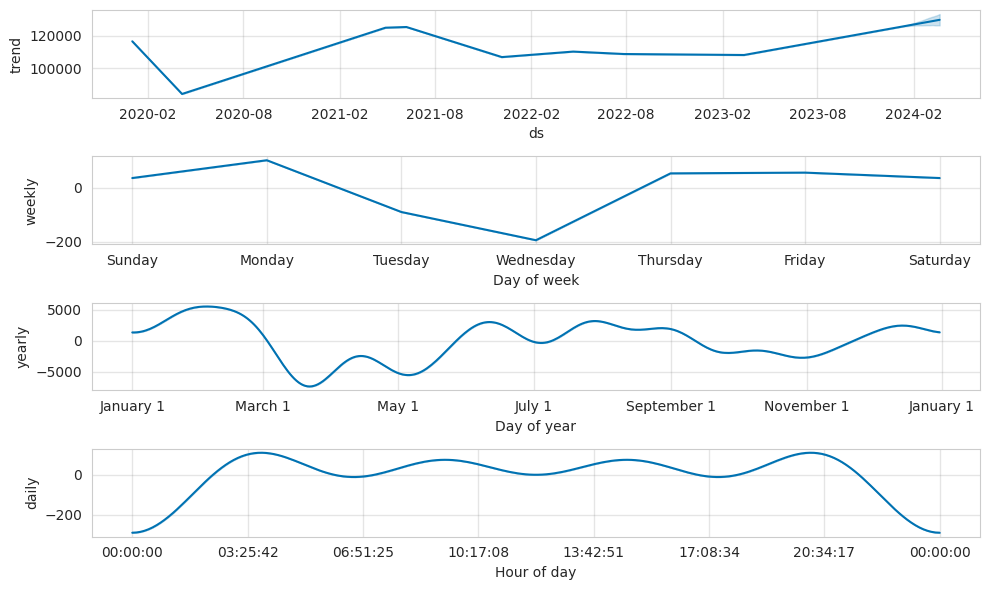

In [460]:
# plot de previsões por escalas de tempo diferentes
modelo.plot_components(previsao, figsize=(10, 6));

In [461]:
# Extrair as colunas relevantes dos DataFrames
previsao_cols = ['ds', 'yhat']
valores_reais_cols = ['ds', 'y']

previsao = previsao[previsao_cols]
valores_reais = train_data[valores_reais_cols]

# Mesclar os DataFrames nas colunas 'ds' para comparar previsões e valores reais
resultados = pd.merge(previsao, valores_reais, on='ds', how='inner')

# Calcular o erro percentual absoluto para cada ponto de dados
resultados['erro_percentual_absoluto'] = np.abs((resultados['y'] - resultados['yhat']) / resultados['y']) * 100

# Calcular o MAPE
mape = np.mean(resultados['erro_percentual_absoluto'])
mape_decimal = np.round(mape / 100, 2)

print(f'MAPE decimal: {mape_decimal:.2f}')
print(f"MAPE: {mape:.2f}%")


MAPE decimal: 0.03
MAPE: 3.33%


In [462]:
# https://www.itm-conferences.org/articles/itmconf/pdf/2022/04/itmconf_icacc2022_03060.pdf
# https://www.phdata.io/blog/facebook-prophet-tutorial-time-series-forecasting

forecast_sub = previsao[['ds', 'yhat']]
forecast_sub['ds'] = forecast_sub['ds'].astype(str)

test_sub = train_data[['ds', 'y']]
test_sub['ds'] = test_sub['ds'].astype(str)

eval_df = test_sub.merge(forecast_sub, on=['ds'], how='left')
eval_df['abs_error'] = abs(eval_df['y'] - eval_df['yhat'])
eval_df['daily_FA'] = 1 - (eval_df['abs_error'] / eval_df['y'])

total_y = sum(eval_df['y'])
total_error = sum(eval_df['abs_error'])
forecast_accuracy = 1 - (total_error / total_y)
forecast_accuracy_percent = forecast_accuracy * 100

agreggate = (np.round(forecast_accuracy, 2) + np.round(mape_decimal, 2)) * 100

print(f'Acurácia do modelo: {forecast_accuracy_percent:.2f}%')
print(f'Agregado da acurácia + erro: {agreggate:.2f}%')

Acurácia do modelo: 96.81%
Agregado da acurácia + erro: 100.00%


In [463]:
from prophet.diagnostics import cross_validation

# também podemos efetuar um cross validation para verificar o comportamento das predições para o próximo 1 ano
df_cv = cross_validation(modelo, initial='730 days', period='180 days', horizon = '365 days')

INFO:prophet:Making 2 forecasts with cutoffs between 2022-06-25 00:00:00 and 2022-12-22 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpv5n8rnw4/o_435ghw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv5n8rnw4/wk70z3oj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51986', 'data', 'file=/tmp/tmpv5n8rnw4/o_435ghw.json', 'init=/tmp/tmpv5n8rnw4/wk70z3oj.json', 'output', 'file=/tmp/tmpv5n8rnw4/prophet_modelpue4o5tv/prophet_model-20240102005649.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:56:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:56:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv5n8rnw4/nbxwbmay.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv5n8rnw4/spvlm1i8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

In [464]:
from prophet.diagnostics import performance_metrics

df_p = performance_metrics(df_cv)
df_p

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,36 days,9.904336e+07,9952.053195,8733.959552,0.086114,0.090467,0.081440,0.435897
1,37 days,1.006622e+08,10033.052938,8892.943894,0.087704,0.090467,0.082955,0.410256
2,38 days,9.928651e+07,9964.261686,8809.717580,0.086835,0.080129,0.082153,0.410256
3,39 days,9.802904e+07,9900.961578,8752.025115,0.086135,0.079207,0.081519,0.410256
4,40 days,9.457779e+07,9725.111200,8528.474543,0.083758,0.068396,0.079312,0.435897
...,...,...,...,...,...,...,...,...
270,361 days,2.644465e+08,16261.811342,15928.410785,0.132801,0.123919,0.142844,1.000000
271,362 days,2.745651e+08,16570.006976,16209.102092,0.134285,0.123919,0.144590,1.000000
272,363 days,2.762706e+08,16621.389304,16278.707211,0.134392,0.124219,0.144687,1.000000
273,364 days,2.778457e+08,16668.703037,16331.962363,0.134356,0.124219,0.144631,1.000000


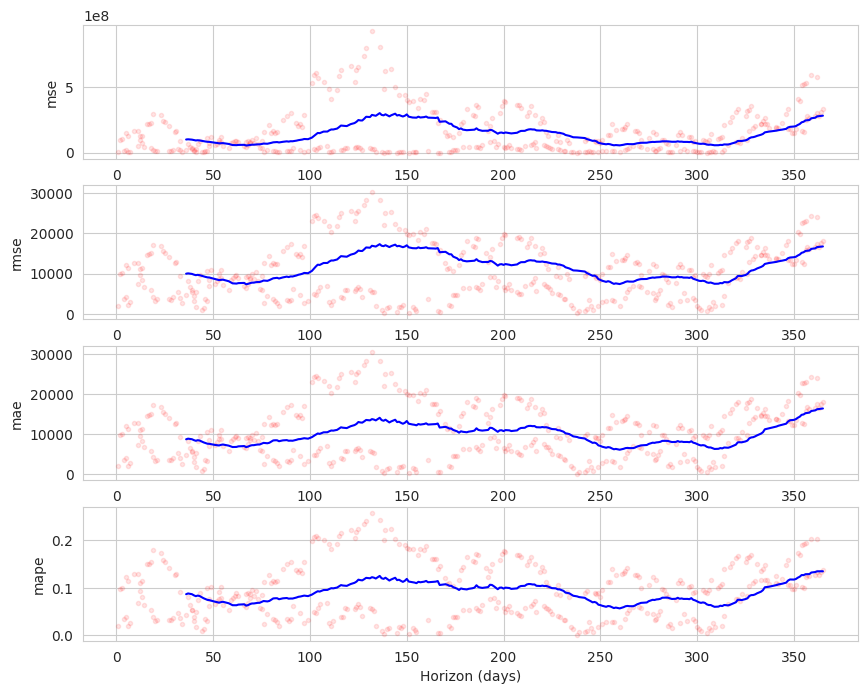

In [465]:
from prophet.plot import plot_cross_validation_metric

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10,8))
plot_cross_validation_metric(df_cv, metric='mse', point_color='red', ax=ax1)
plot_cross_validation_metric(df_cv, metric='rmse', point_color='red', ax=ax2)
plot_cross_validation_metric(df_cv, metric='mae', point_color='red', ax=ax3)
plot_cross_validation_metric(df_cv, metric='mape', point_color='red', ax=ax4)
plt.show()

### Comentário
Nos gráficos acima, podemos visualizar o comportamento dos indicadores de erro do modelo. Os gráficos estão divididos em MSE, RMSE, MAE e MAPE. A seguir, iremos comparar as predições da última semana de 2023 com a realidade e ver como o modelo está performando.

In [466]:
validacao_prophet = obter_dados_ticker(ticker = '^BVSP', inicio = '2023-12-25', fim = '2023-12-30')
validacao_prophet = validacao_prophet[['Close']]
validacao_prophet.head()

[*********************100%%**********************]  1 of 1 completed
Dados originais
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3 entries, 2023-12-26 to 2023-12-28
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       3 non-null      float64
 1   High       3 non-null      float64
 2   Low        3 non-null      float64
 3   Close      3 non-null      float64
 4   Adj Close  3 non-null      float64
 5   Volume     3 non-null      int64  
dtypes: float64(5), int64(1)
memory usage: 168.0 bytes
Dados tratados
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3 entries, 2023-12-26 to 2023-12-28
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       3 non-null      float64
 1   High       3 non-null      float64
 2   Low        3 non-null      float64
 3   Close      3 non-null      float64
 4   Adj Close  3 non-null      float64
 5 

,Close
Date,
2023-12-26,133533.0
2023-12-27,134194.0
2023-12-28,134185.0


In [467]:
# dia 29, a BOVESPA não operou
previsao.query('ds >= "2023-12-26" and ds <= "2023-12-28"')

,ds,yhat
795,2023-12-26,126051.915350
796,2023-12-27,125917.226346
797,2023-12-28,126140.733635


### Comentário
Mesmo um modelo Prophet com cerca de **96.8% de acurácia e 3.2% de erro**, os valores previstos ainda estão distantes da realidade. Na próxima seção, iremos abordar o problema com um Rede LSTM.

# 5) Aplicação de Rede LSTM e análise de resultados

In [468]:
import plotly.graph_objects as go

# Para deep learning
from keras.models import Sequential
from keras.layers import LSTM,Dense,Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanSquaredError
from keras.models import load_model
from keras.preprocessing.sequence import TimeseriesGenerator

# Para machine learning
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [469]:
df_lstm = obter_dados_ticker(ticker='^BVSP')
df_lstm.reset_index(inplace=True)

[*********************100%%**********************]  1 of 1 completed
Dados originais
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 990 entries, 2020-01-02 to 2023-12-22
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       990 non-null    float64
 1   High       990 non-null    float64
 2   Low        990 non-null    float64
 3   Close      990 non-null    float64
 4   Adj Close  990 non-null    float64
 5   Volume     990 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 54.1 KB
Dados tratados
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 990 entries, 2020-01-02 to 2023-12-22
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       990 non-null    float64
 1   High       990 non-null    float64
 2   Low        990 non-null    float64
 3   Close      990 non-null    float64
 4   Adj Close  990 non-null    float64
 5 

In [470]:
df_lstm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 990 entries, 0 to 989
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    990 non-null    datetime64[ns]
 1   Close   990 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 15.6 KB


In [471]:
def executar_lstm(serie: pd.Series, epochs: int = 20):
  lstm_values = serie.values.reshape(-1, 1)
  split_percent = 0.80
  split = int(split_percent * len(lstm_values))

  print('pré normalização')
  display(lstm_values[:5])

  scaler = MinMaxScaler(feature_range=(0, 1))
  scaler = scaler.fit(lstm_values)
  lstm_values_transformed = scaler.transform(lstm_values)

  print('pós normalização')
  display(lstm_values_transformed[:5])

  # poderiamos utilizar o train_test_split() aqui também
  # lstm_train, lstm_test = train_test_split(lstm_values_transformed, test_size = 0.2, random_state = 777, shuffle = False)

  lstm_train = lstm_values_transformed[:split]
  lstm_test = lstm_values_transformed[split:]

  lstm_timestamp_train = df_lstm['Date'][:split]
  lstm_timestamp_test = df_lstm['Date'][split:]

  print(f'Total treino: {len(lstm_train)}')
  print(f'Total teste: {len(lstm_test)}')

  np.random.seed(7)
  look_back = 5
  neuronios = 100

  # gerando sequências temporais para treinamento e teste do LSTM
  train_generator = TimeseriesGenerator(lstm_train, lstm_train, length=look_back, batch_size=20)
  test_generator = TimeseriesGenerator(lstm_test, lstm_test, length=look_back, batch_size=1)

  # configuração do LSTM
  model = Sequential()
  model.add(LSTM(neuronios, activation='relu', input_shape=(look_back,1)))
  model.add(Dense(1)),
  model.summary()

  # treino do LSTM
  optimizer = Adam(learning_rate=0.001)
  model.compile(optimizer=optimizer, loss='mse', metrics=[MeanSquaredError()])
  model.fit(train_generator, epochs=epochs, verbose=1)

  # faz previsões com base nos testes
  test_predictions = model.predict(test_generator)

  # reverte a normalização do MinMaxScaler
  test_predictions_inv = scaler.inverse_transform(test_predictions.reshape(-1, 1))
  test_actuals_inv = scaler.inverse_transform(np.array(lstm_test).reshape(-1, 1))

  # ajusta dimensões
  test_actuals_inv = test_actuals_inv[:len(test_predictions_inv)]

  # cálculo do MSE
  lstm_mse = model.evaluate(test_generator, verbose=1)
  print(f'MSE (Erro Quadrático Médio): {lstm_mse[0]:.8f}')

  # cálculo do MAPE
  lstm_mape = np.mean(np.abs((test_actuals_inv - test_predictions_inv) / test_actuals_inv)) * 100
  print(f'MAPE: {mape:.8f}')

  # cálculo do RMSE
  lstm_rmse = np.sqrt(lstm_mse[0])
  print(f'RMSE: {lstm_rmse:.8f}')

  prediction = model.predict(test_generator)

  plot_lstm_train = lstm_train.reshape((-1))
  plot_lstm_test = lstm_test.reshape((-1))
  prediction = prediction.reshape((-1))

  trace1 = go.Scatter(
      x = lstm_timestamp_train,
      y = plot_lstm_train,
      mode = 'lines',
      name = 'Data'
  )

  trace2 = go.Scatter(
      x = lstm_timestamp_test,
      y = prediction,
      mode = 'lines',
      name = 'Predição'
  )

  trace3 = go.Scatter(
      x = lstm_timestamp_test,
      y = plot_lstm_test,
      mode='lines',
      name = 'Ground Truth'
  )

  layout = go.Layout(
      title = "Predições IBOVESPA",
      xaxis = {'title' : "Data"},
      yaxis = {'title' : "Fechamento"}
  )

  fig = go.Figure(data=[trace1, trace2, trace3], layout=layout)
  fig.show()

  return (model, scaler, lstm_values_transformed)

In [472]:
lstm_model, lstm_scaler, lstm_values_transformed = executar_lstm(df_lstm.Close, epochs=100)

pré normalização


array([[118573.],
       [117707.],
       [116878.],
       [116662.],
       [116247.]])

pós normalização


array([[0.79503635],
       [0.78251883],
       [0.77053611],
       [0.76741396],
       [0.76141538]])

Total treino: 792
Total teste: 198
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 100)               40800     
                                                                 
 dense_6 (Dense)             (None, 1)                 101       
                                                                 
Total params: 40901 (159.77 KB)
Trainable params: 40901 (159.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
40/40 [==============================] - 3s 6ms/step - loss: 0.2066 - mean_squared_error: 0.2066
Epoch 2/100
40/40 [==============================] - 0s 4ms/step - loss: 0.0061 - mean_squared_error: 0.0061
Epoch 3/100
40/40 [==============================] - 0s 4ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 4/100
40/40 [==============================]

### Comentário
Primeiro aplicamos o LSTM no preço de fechamento diário. Agora iremos "suavizar" o preço e reaplicar o modelo para tentarmos obter um melhor resultado.

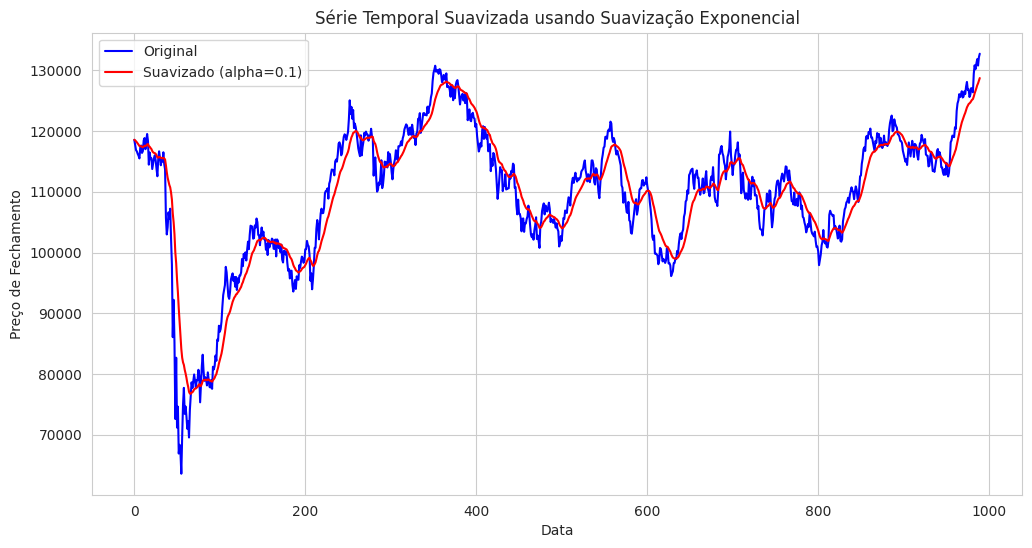

In [522]:
# suaviza o preço de fechamento
alpha = 0.1
df_lstm['Smoothed_Close'] = df_lstm.Close.ewm(alpha = alpha, adjust = False).mean()

# plot da linha suavizada
plt.figure(figsize=(12, 6))
plt.plot(df_lstm.index, df_lstm['Close'], label='Original', color='blue')
plt.plot(df_lstm.index, df_lstm['Smoothed_Close'], label=f'Suavizado (alpha={alpha})', color='red')
plt.title('Série Temporal Suavizada usando Suavização Exponencial')
plt.xlabel('Data')
plt.ylabel('Preço de Fechamento')
plt.legend()
plt.show()

In [523]:
lstm_model_smooth, lstm_scaler_smooth, lstm_values_transformed_smooth = executar_lstm(df_lstm.Smoothed_Close, epochs=100)

pré normalização


array([[118573.    ],
       [118486.4   ],
       [118325.56  ],
       [118159.204 ],
       [117967.9836]])

pós normalização


array([[0.80449029],
       [0.80282542],
       [0.79973328],
       [0.7965351 ],
       [0.7928589 ]])

Total treino: 792
Total teste: 198
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 100)               40800     
                                                                 
 dense_10 (Dense)            (None, 1)                 101       
                                                                 
Total params: 40901 (159.77 KB)
Trainable params: 40901 (159.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
40/40 [==============================] - 2s 3ms/step - loss: 0.1911 - mean_squared_error: 0.1911
Epoch 2/100
40/40 [==============================] - 0s 3ms/step - loss: 0.0068 - mean_squared_error: 0.0068
Epoch 3/100
40/40 [==============================] - 0s 3ms/step - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 4/100
40/40 [==============================

In [524]:
look_back = 5

# Função para prever os próximos 'num_prediction' pontos da série temporal
# Utiliza o modelo treinado para prever cada ponto sequencialmente
# A cada iteração, adiciona a previsão à lista 'prediction_list'
def lstm_predict(num_prediction, series, modelo):
    prediction_list = series[-look_back:]

    for _ in range(num_prediction):
        x = prediction_list[-look_back:]
        x = x.reshape((1, look_back, 1))
        out = modelo.predict(x)[0][0]
        prediction_list = np.append(prediction_list, out)

    prediction_list = prediction_list[look_back - 1:]

    return prediction_list

# Função para gerar as datas dos próximos 'num_prediction' dias
# Assume que o DataFrame 'df' possui uma coluna 'Date' contendo as datas
def lstm_predict_dates(num_prediction):
    last_date = df_lstm['Date'].values[-1]
    prediction_dates = pd.date_range(last_date, periods=num_prediction + 1).tolist()

    return prediction_dates

num_prediction = 9 # definição dos próximos dias
forecast = lstm_predict(num_prediction, lstm_values_transformed_smooth.reshape((-1)), lstm_model_smooth) #resultado de novos dias
forecast_dates = lstm_predict_dates(num_prediction)

1/1 [==============================] - 0s 15ms/step


In [525]:
df = pd.DataFrame(df_lstm)
df_past = df[['Date', 'Smoothed_Close']]
df_past.rename(columns={'Smoothed_Close': 'Actual'}, inplace=True)
df_past['Date'] = pd.to_datetime(df_past['Date'])
df_past['Forecast'] = np.nan
df_past['Forecast'].iloc[-1] = df_past['Actual'].iloc[-1]
df_past.tail()

,Date,Actual,Forecast
985,2023-12-18,127059.677327,NaN
986,2023-12-19,127538.809594,NaN
987,2023-12-20,127865.328635,NaN
988,2023-12-21,128296.995771,NaN
989,2023-12-22,128742.596194,128742.596194


In [526]:
# remove o MinMaxScaler
forecast = forecast.reshape(-1, 1)
forecast = lstm_scaler_smooth.inverse_transform(forecast)
forecast

array([[128742.59619427],
       [129112.50921248],
       [129536.76576178],
       [129965.71009173],
       [130418.53357939],
       [130886.85898716],
       [131372.72016695],
       [131879.97399647],
       [132409.51338633],
       [132964.07287523]])

In [527]:
# processa o df com os dados previstos
df_future = pd.DataFrame(columns=['Date', 'Actual', 'Forecast'])
df_future['Date'] = forecast_dates
df_future['Forecast'] = forecast.flatten()
df_future['Actual'] = np.nan
df_future.tail()

,Date,Actual,Forecast
5,2023-12-27,NaN,130886.858987
6,2023-12-28,NaN,131372.720167
7,2023-12-29,NaN,131879.973996
8,2023-12-30,NaN,132409.513386
9,2023-12-31,NaN,132964.072875


In [528]:
# junta ambos os dataframes
frames = [df_past, df_future]
results = pd.concat(frames, ignore_index=True)
results.tail(20)

,Date,Actual,Forecast
980,2023-12-11,125157.150836,NaN
981,2023-12-12,125281.735752,NaN
982,2023-12-13,125700.062177,NaN
983,2023-12-14,126214.255959,NaN
984,2023-12-15,126612.530363,NaN
985,2023-12-18,127059.677327,NaN
986,2023-12-19,127538.809594,NaN
987,2023-12-20,127865.328635,NaN
988,2023-12-21,128296.995771,NaN
989,2023-12-22,128742.596194,128742.596194


In [529]:
# obtém os valores atuais do fechamento do IBOVESPA para comparar com os dados previstos (desta vez até 29/12)
# vamos substituir o "Actual" que sofreu suavizaçao pelo valor original
# df_atual = obter_dados_ticker('^BVSP', inicio='2023-01-01', fim='2023-12-29')
# df_atual.rename(columns={'Close': 'Actual'}, inplace=True)
# df_atual.reset_index(inplace=True)
# df_atual.head()

# gera o dataframe final com os valores reais do final do mês de dezembro/2023
# df_final = pd.merge(results, df_atual, how='left', on=['Date'])
# df_final['Actual'] = df_final['Actual_x'].combine_first(df_final['Actual_y'])
# df_final.drop(['Actual_x', 'Actual_y'], axis=1, inplace=True)
# df_final.set_index('Date', inplace=True)
# df_final['Actual'].fillna(method='ffill', inplace=True)
# df_final.tail(10)

In [530]:
results2023 =  results.loc['2023-01-01':]
results2023 = results2023.set_index('Date')

plot_data = [
    go.Scatter(
        x=results2023.index,
        y=results2023['Actual'],
        name='actual'
    ),
    go.Scatter(
        x=results2023.index,
        y=results2023['Forecast'],
        name='prediction'
    )
]

plot_layout = go.Layout(
    title='Forecast IBOVESPA'
)

fig = go.Figure(data=plot_data, layout=plot_layout)
fig.show()

### Comentário
Conforme observado, o modelo com a curva de fechamento suavizada previou valores bem próximos da realidade!

# 6) Armazenando o modelo LSTM

In [531]:
from keras.models import load_model

In [532]:
lstm_model_smooth.save('/content/lstm')

In [533]:
neural_model = load_model('/content/lstm')

In [538]:
num_prediction = 7
forecast = lstm_predict(num_prediction, lstm_values_transformed_smooth.reshape((-1)), neural_model)
forecast_dates = lstm_predict_dates(num_prediction)

1/1 [==============================] - 0s 74ms/step


In [539]:
forecast = forecast.reshape(-1, 1)
forecast = lstm_scaler_smooth.inverse_transform(forecast)
forecast

array([[128742.59619427],
       [129112.50921248],
       [129536.76576178],
       [129965.71009173],
       [130418.53357939],
       [130886.85898716],
       [131372.72016695],
       [131879.97399647]])

# 7) Dashboard interativo no Streamlit
Acesse o link a seguir para utilizar o modelo diretamente via streamlit.<br/>
https://postech-tech-challenge-2-danilo-henrique-achcar.streamlit.app/